In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0,
    'binarize'      : True,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_0


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3737275, 828)
(3737275, 7)
validation
(449225, 828)
(449225, 7)
test
(529121, 828)
(529121, 7)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 7)                 903       


Total params: 1538823 (5.87 MB)


Trainable params: 1538823 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/374 [..............................] - ETA: 8:32 - loss: 2.2925 - STD: 0.0776 - MAE: 0.2489

  4/374 [..............................] - ETA: 1:33 - loss: 2.0582 - STD: 0.0459 - MAE: 0.2452

  7/374 [..............................] - ETA: 49s - loss: 2.0203 - STD: 0.0684 - MAE: 0.2418 

 10/374 [..............................] - ETA: 35s - loss: 1.9962 - STD: 0.0661 - MAE: 0.2415

 13/374 [>.............................] - ETA: 27s - loss: 1.9787 - STD: 0.0570 - MAE: 0.2418

 17/374 [>.............................] - ETA: 21s - loss: 1.9667 - STD: 0.0499 - MAE: 0.2422

 20/374 [>.............................] - ETA: 19s - loss: 1.9602 - STD: 0.0477 - MAE: 0.2422

 23/374 [>.............................] - ETA: 17s - loss: 1.9541 - STD: 0.0466 - MAE: 0.2422

 26/374 [=>............................] - ETA: 15s - loss: 1.9497 - STD: 0.0466 - MAE: 0.2421

 29/374 [=>............................] - ETA: 14s - loss: 1.9466 - STD: 0.0468 - MAE: 0.2420

 32/374 [=>............................] - ETA: 13s - loss: 1.9432 - STD: 0.0466 - MAE: 0.2419

 36/374 [=>............................] - ETA: 12s - loss: 1.9397 - STD: 0.0455 - MAE: 0.2419

 39/374 [==>...........................] - ETA: 12s - loss: 1.9374 - STD: 0.0444 - MAE: 0.2420

 43/374 [==>...........................] - ETA: 11s - loss: 1.9347 - STD: 0.0436 - MAE: 0.2419

 46/374 [==>...........................] - ETA: 10s - loss: 1.9327 - STD: 0.0435 - MAE: 0.2419

 49/374 [==>...........................] - ETA: 10s - loss: 1.9306 - STD: 0.0434 - MAE: 0.2418

 52/374 [===>..........................] - ETA: 10s - loss: 1.9283 - STD: 0.0431 - MAE: 0.2418

 55/374 [===>..........................] - ETA: 9s - loss: 1.9255 - STD: 0.0428 - MAE: 0.2417 

 58/374 [===>..........................] - ETA: 9s - loss: 1.9221 - STD: 0.0425 - MAE: 0.2416

 61/374 [===>..........................] - ETA: 9s - loss: 1.9175 - STD: 0.0425 - MAE: 0.2414

 64/374 [====>.........................] - ETA: 8s - loss: 1.9114 - STD: 0.0429 - MAE: 0.2411

 67/374 [====>.........................] - ETA: 8s - loss: 1.9043 - STD: 0.0437 - MAE: 0.2407

 70/374 [====>.........................] - ETA: 8s - loss: 1.8952 - STD: 0.0449 - MAE: 0.2401

 73/374 [====>.........................] - ETA: 8s - loss: 1.8843 - STD: 0.0464 - MAE: 0.2394

 76/374 [=====>........................] - ETA: 8s - loss: 1.8715 - STD: 0.0485 - MAE: 0.2385

 79/374 [=====>........................] - ETA: 7s - loss: 1.8585 - STD: 0.0509 - MAE: 0.2375

 82/374 [=====>........................] - ETA: 7s - loss: 1.8455 - STD: 0.0535 - MAE: 0.2365

 85/374 [=====>........................] - ETA: 7s - loss: 1.8324 - STD: 0.0563 - MAE: 0.2354

 88/374 [======>.......................] - ETA: 7s - loss: 1.8199 - STD: 0.0590 - MAE: 0.2344

 91/374 [======>.......................] - ETA: 7s - loss: 1.8078 - STD: 0.0618 - MAE: 0.2333

 94/374 [======>.......................] - ETA: 7s - loss: 1.7962 - STD: 0.0644 - MAE: 0.2323

 97/374 [======>.......................] - ETA: 6s - loss: 1.7849 - STD: 0.0669 - MAE: 0.2313

100/374 [=======>......................] - ETA: 6s - loss: 1.7740 - STD: 0.0694 - MAE: 0.2303

103/374 [=======>......................] - ETA: 6s - loss: 1.7634 - STD: 0.0716 - MAE: 0.2294

106/374 [=======>......................] - ETA: 6s - loss: 1.7531 - STD: 0.0737 - MAE: 0.2285

109/374 [=======>......................] - ETA: 6s - loss: 1.7430 - STD: 0.0758 - MAE: 0.2276

112/374 [=======>......................] - ETA: 6s - loss: 1.7334 - STD: 0.0779 - MAE: 0.2268

115/374 [========>.....................] - ETA: 6s - loss: 1.7241 - STD: 0.0798 - MAE: 0.2259

118/374 [========>.....................] - ETA: 6s - loss: 1.7149 - STD: 0.0817 - MAE: 0.2251

121/374 [========>.....................] - ETA: 5s - loss: 1.7060 - STD: 0.0836 - MAE: 0.2243

124/374 [========>.....................] - ETA: 5s - loss: 1.6976 - STD: 0.0854 - MAE: 0.2236

127/374 [=========>....................] - ETA: 5s - loss: 1.6893 - STD: 0.0871 - MAE: 0.2228

130/374 [=========>....................] - ETA: 5s - loss: 1.6813 - STD: 0.0887 - MAE: 0.2221

133/374 [=========>....................] - ETA: 5s - loss: 1.6736 - STD: 0.0903 - MAE: 0.2214

136/374 [=========>....................] - ETA: 5s - loss: 1.6663 - STD: 0.0918 - MAE: 0.2207

139/374 [==========>...................] - ETA: 5s - loss: 1.6591 - STD: 0.0933 - MAE: 0.2201

142/374 [==========>...................] - ETA: 5s - loss: 1.6520 - STD: 0.0948 - MAE: 0.2194

145/374 [==========>...................] - ETA: 5s - loss: 1.6449 - STD: 0.0962 - MAE: 0.2188

148/374 [==========>...................] - ETA: 5s - loss: 1.6380 - STD: 0.0976 - MAE: 0.2181

151/374 [===========>..................] - ETA: 5s - loss: 1.6314 - STD: 0.0990 - MAE: 0.2175

154/374 [===========>..................] - ETA: 4s - loss: 1.6250 - STD: 0.1003 - MAE: 0.2169

157/374 [===========>..................] - ETA: 4s - loss: 1.6188 - STD: 0.1015 - MAE: 0.2164

160/374 [===========>..................] - ETA: 4s - loss: 1.6127 - STD: 0.1027 - MAE: 0.2158

163/374 [============>.................] - ETA: 4s - loss: 1.6067 - STD: 0.1039 - MAE: 0.2152

166/374 [============>.................] - ETA: 4s - loss: 1.6009 - STD: 0.1051 - MAE: 0.2147

169/374 [============>.................] - ETA: 4s - loss: 1.5952 - STD: 0.1063 - MAE: 0.2142

172/374 [============>.................] - ETA: 4s - loss: 1.5895 - STD: 0.1074 - MAE: 0.2136

175/374 [=============>................] - ETA: 4s - loss: 1.5840 - STD: 0.1085 - MAE: 0.2131

178/374 [=============>................] - ETA: 4s - loss: 1.5787 - STD: 0.1095 - MAE: 0.2126

181/374 [=============>................] - ETA: 4s - loss: 1.5734 - STD: 0.1106 - MAE: 0.2121

184/374 [=============>................] - ETA: 4s - loss: 1.5682 - STD: 0.1117 - MAE: 0.2116

187/374 [==============>...............] - ETA: 4s - loss: 1.5631 - STD: 0.1127 - MAE: 0.2111

190/374 [==============>...............] - ETA: 3s - loss: 1.5582 - STD: 0.1137 - MAE: 0.2106

193/374 [==============>...............] - ETA: 3s - loss: 1.5533 - STD: 0.1146 - MAE: 0.2101

197/374 [==============>...............] - ETA: 3s - loss: 1.5469 - STD: 0.1159 - MAE: 0.2095

200/374 [===============>..............] - ETA: 3s - loss: 1.5422 - STD: 0.1169 - MAE: 0.2090

203/374 [===============>..............] - ETA: 3s - loss: 1.5376 - STD: 0.1178 - MAE: 0.2085

206/374 [===============>..............] - ETA: 3s - loss: 1.5330 - STD: 0.1187 - MAE: 0.2081

209/374 [===============>..............] - ETA: 3s - loss: 1.5284 - STD: 0.1197 - MAE: 0.2076

212/374 [================>.............] - ETA: 3s - loss: 1.5241 - STD: 0.1205 - MAE: 0.2072

215/374 [================>.............] - ETA: 3s - loss: 1.5197 - STD: 0.1214 - MAE: 0.2067

218/374 [================>.............] - ETA: 3s - loss: 1.5154 - STD: 0.1222 - MAE: 0.2063

221/374 [================>.............] - ETA: 3s - loss: 1.5111 - STD: 0.1231 - MAE: 0.2059

224/374 [================>.............] - ETA: 3s - loss: 1.5069 - STD: 0.1239 - MAE: 0.2055

227/374 [=================>............] - ETA: 3s - loss: 1.5030 - STD: 0.1247 - MAE: 0.2050

230/374 [=================>............] - ETA: 2s - loss: 1.4991 - STD: 0.1255 - MAE: 0.2046

233/374 [=================>............] - ETA: 2s - loss: 1.4951 - STD: 0.1262 - MAE: 0.2042

236/374 [=================>............] - ETA: 2s - loss: 1.4913 - STD: 0.1270 - MAE: 0.2039

239/374 [==================>...........] - ETA: 2s - loss: 1.4875 - STD: 0.1277 - MAE: 0.2035

242/374 [==================>...........] - ETA: 2s - loss: 1.4838 - STD: 0.1285 - MAE: 0.2031

245/374 [==================>...........] - ETA: 2s - loss: 1.4801 - STD: 0.1292 - MAE: 0.2027

248/374 [==================>...........] - ETA: 2s - loss: 1.4765 - STD: 0.1299 - MAE: 0.2024

251/374 [===================>..........] - ETA: 2s - loss: 1.4730 - STD: 0.1306 - MAE: 0.2020

254/374 [===================>..........] - ETA: 2s - loss: 1.4694 - STD: 0.1313 - MAE: 0.2016

257/374 [===================>..........] - ETA: 2s - loss: 1.4659 - STD: 0.1319 - MAE: 0.2013

260/374 [===================>..........] - ETA: 2s - loss: 1.4626 - STD: 0.1326 - MAE: 0.2009

263/374 [====================>.........] - ETA: 2s - loss: 1.4593 - STD: 0.1332 - MAE: 0.2006

266/374 [====================>.........] - ETA: 2s - loss: 1.4561 - STD: 0.1339 - MAE: 0.2003

269/374 [====================>.........] - ETA: 2s - loss: 1.4531 - STD: 0.1345 - MAE: 0.2000

272/374 [====================>.........] - ETA: 2s - loss: 1.4499 - STD: 0.1351 - MAE: 0.1996

275/374 [=====================>........] - ETA: 2s - loss: 1.4467 - STD: 0.1357 - MAE: 0.1993

278/374 [=====================>........] - ETA: 1s - loss: 1.4436 - STD: 0.1363 - MAE: 0.1990

281/374 [=====================>........] - ETA: 1s - loss: 1.4406 - STD: 0.1369 - MAE: 0.1987

284/374 [=====================>........] - ETA: 1s - loss: 1.4376 - STD: 0.1375 - MAE: 0.1984

287/374 [======================>.......] - ETA: 1s - loss: 1.4347 - STD: 0.1380 - MAE: 0.1981

290/374 [======================>.......] - ETA: 1s - loss: 1.4318 - STD: 0.1386 - MAE: 0.1978

293/374 [======================>.......] - ETA: 1s - loss: 1.4291 - STD: 0.1391 - MAE: 0.1975

296/374 [======================>.......] - ETA: 1s - loss: 1.4263 - STD: 0.1397 - MAE: 0.1972

299/374 [======================>.......] - ETA: 1s - loss: 1.4236 - STD: 0.1402 - MAE: 0.1969

302/374 [=======================>......] - ETA: 1s - loss: 1.4207 - STD: 0.1407 - MAE: 0.1966

305/374 [=======================>......] - ETA: 1s - loss: 1.4180 - STD: 0.1412 - MAE: 0.1964

308/374 [=======================>......] - ETA: 1s - loss: 1.4153 - STD: 0.1418 - MAE: 0.1961

312/374 [========================>.....] - ETA: 1s - loss: 1.4118 - STD: 0.1424 - MAE: 0.1957

315/374 [========================>.....] - ETA: 1s - loss: 1.4092 - STD: 0.1429 - MAE: 0.1955

318/374 [========================>.....] - ETA: 1s - loss: 1.4066 - STD: 0.1434 - MAE: 0.1952

321/374 [========================>.....] - ETA: 1s - loss: 1.4040 - STD: 0.1439 - MAE: 0.1949

324/374 [========================>.....] - ETA: 1s - loss: 1.4015 - STD: 0.1443 - MAE: 0.1947

328/374 [=========================>....] - ETA: 0s - loss: 1.3982 - STD: 0.1450 - MAE: 0.1943

331/374 [=========================>....] - ETA: 0s - loss: 1.3957 - STD: 0.1454 - MAE: 0.1941

334/374 [=========================>....] - ETA: 0s - loss: 1.3934 - STD: 0.1459 - MAE: 0.1938

337/374 [==========================>...] - ETA: 0s - loss: 1.3910 - STD: 0.1463 - MAE: 0.1936

340/374 [==========================>...] - ETA: 0s - loss: 1.3887 - STD: 0.1468 - MAE: 0.1934

343/374 [==========================>...] - ETA: 0s - loss: 1.3864 - STD: 0.1472 - MAE: 0.1931

346/374 [==========================>...] - ETA: 0s - loss: 1.3842 - STD: 0.1476 - MAE: 0.1929

349/374 [==========================>...] - ETA: 0s - loss: 1.3820 - STD: 0.1480 - MAE: 0.1927

352/374 [===========================>..] - ETA: 0s - loss: 1.3797 - STD: 0.1485 - MAE: 0.1924

355/374 [===========================>..] - ETA: 0s - loss: 1.3775 - STD: 0.1489 - MAE: 0.1922

358/374 [===========================>..] - ETA: 0s - loss: 1.3753 - STD: 0.1493 - MAE: 0.1920

361/374 [===========================>..] - ETA: 0s - loss: 1.3731 - STD: 0.1497 - MAE: 0.1918

364/374 [============================>.] - ETA: 0s - loss: 1.3711 - STD: 0.1501 - MAE: 0.1915

367/374 [============================>.] - ETA: 0s - loss: 1.3690 - STD: 0.1505 - MAE: 0.1913

370/374 [============================>.] - ETA: 0s - loss: 1.3671 - STD: 0.1509 - MAE: 0.1911

373/374 [============================>.] - ETA: 0s - loss: 1.3650 - STD: 0.1512 - MAE: 0.1909

374/374 [==============================] - 10s 23ms/step - loss: 1.3644 - STD: 0.1514 - MAE: 0.1908 - val_loss: 1.1151 - val_STD: 0.1937 - val_MAE: 0.1646


Epoch 2/10000


  1/374 [..............................] - ETA: 18s - loss: 1.1049 - STD: 0.1954 - MAE: 0.1650

  4/374 [..............................] - ETA: 6s - loss: 1.1090 - STD: 0.1967 - MAE: 0.1650 

  7/374 [..............................] - ETA: 6s - loss: 1.1104 - STD: 0.1971 - MAE: 0.1649

 10/374 [..............................] - ETA: 6s - loss: 1.1078 - STD: 0.1980 - MAE: 0.1645

 13/374 [>.............................] - ETA: 6s - loss: 1.1063 - STD: 0.1982 - MAE: 0.1643

 17/374 [>.............................] - ETA: 6s - loss: 1.1047 - STD: 0.1985 - MAE: 0.1641

 20/374 [>.............................] - ETA: 6s - loss: 1.1043 - STD: 0.1987 - MAE: 0.1640

 23/374 [>.............................] - ETA: 6s - loss: 1.1040 - STD: 0.1991 - MAE: 0.1638

 27/374 [=>............................] - ETA: 5s - loss: 1.1048 - STD: 0.1992 - MAE: 0.1639

 30/374 [=>............................] - ETA: 5s - loss: 1.1040 - STD: 0.1994 - MAE: 0.1637

 33/374 [=>............................] - ETA: 5s - loss: 1.1032 - STD: 0.1995 - MAE: 0.1637

 36/374 [=>............................] - ETA: 5s - loss: 1.1029 - STD: 0.1995 - MAE: 0.1637

 39/374 [==>...........................] - ETA: 5s - loss: 1.1023 - STD: 0.1996 - MAE: 0.1636

 43/374 [==>...........................] - ETA: 5s - loss: 1.1006 - STD: 0.1997 - MAE: 0.1635

 46/374 [==>...........................] - ETA: 5s - loss: 1.1002 - STD: 0.1997 - MAE: 0.1635

 49/374 [==>...........................] - ETA: 5s - loss: 1.0994 - STD: 0.1998 - MAE: 0.1634

 53/374 [===>..........................] - ETA: 5s - loss: 1.0984 - STD: 0.2000 - MAE: 0.1633

 56/374 [===>..........................] - ETA: 5s - loss: 1.0975 - STD: 0.2001 - MAE: 0.1631

 59/374 [===>..........................] - ETA: 5s - loss: 1.0966 - STD: 0.2003 - MAE: 0.1630

 62/374 [===>..........................] - ETA: 5s - loss: 1.0958 - STD: 0.2003 - MAE: 0.1630

 65/374 [====>.........................] - ETA: 5s - loss: 1.0950 - STD: 0.2004 - MAE: 0.1629

 68/374 [====>.........................] - ETA: 5s - loss: 1.0943 - STD: 0.2005 - MAE: 0.1628

 71/374 [====>.........................] - ETA: 5s - loss: 1.0938 - STD: 0.2006 - MAE: 0.1628

 74/374 [====>.........................] - ETA: 5s - loss: 1.0937 - STD: 0.2007 - MAE: 0.1627

 77/374 [=====>........................] - ETA: 5s - loss: 1.0934 - STD: 0.2008 - MAE: 0.1627

 80/374 [=====>........................] - ETA: 5s - loss: 1.0930 - STD: 0.2009 - MAE: 0.1626

 83/374 [=====>........................] - ETA: 5s - loss: 1.0920 - STD: 0.2011 - MAE: 0.1625

 86/374 [=====>........................] - ETA: 5s - loss: 1.0912 - STD: 0.2011 - MAE: 0.1624

 89/374 [======>.......................] - ETA: 4s - loss: 1.0905 - STD: 0.2012 - MAE: 0.1623

 92/374 [======>.......................] - ETA: 4s - loss: 1.0899 - STD: 0.2013 - MAE: 0.1623

 95/374 [======>.......................] - ETA: 4s - loss: 1.0892 - STD: 0.2014 - MAE: 0.1622

 98/374 [======>.......................] - ETA: 4s - loss: 1.0886 - STD: 0.2015 - MAE: 0.1621

101/374 [=======>......................] - ETA: 4s - loss: 1.0879 - STD: 0.2016 - MAE: 0.1620

104/374 [=======>......................] - ETA: 4s - loss: 1.0872 - STD: 0.2017 - MAE: 0.1619

107/374 [=======>......................] - ETA: 4s - loss: 1.0869 - STD: 0.2018 - MAE: 0.1619

110/374 [=======>......................] - ETA: 4s - loss: 1.0864 - STD: 0.2019 - MAE: 0.1618

113/374 [========>.....................] - ETA: 4s - loss: 1.0856 - STD: 0.2020 - MAE: 0.1617

116/374 [========>.....................] - ETA: 4s - loss: 1.0846 - STD: 0.2021 - MAE: 0.1616

119/374 [========>.....................] - ETA: 4s - loss: 1.0836 - STD: 0.2022 - MAE: 0.1615

122/374 [========>.....................] - ETA: 4s - loss: 1.0830 - STD: 0.2023 - MAE: 0.1615

125/374 [=========>....................] - ETA: 4s - loss: 1.0831 - STD: 0.2024 - MAE: 0.1614

128/374 [=========>....................] - ETA: 4s - loss: 1.0826 - STD: 0.2025 - MAE: 0.1614

131/374 [=========>....................] - ETA: 4s - loss: 1.0825 - STD: 0.2025 - MAE: 0.1613

134/374 [=========>....................] - ETA: 4s - loss: 1.0820 - STD: 0.2026 - MAE: 0.1613

137/374 [=========>....................] - ETA: 4s - loss: 1.0817 - STD: 0.2027 - MAE: 0.1612

140/374 [==========>...................] - ETA: 4s - loss: 1.0811 - STD: 0.2028 - MAE: 0.1612

143/374 [==========>...................] - ETA: 4s - loss: 1.0808 - STD: 0.2029 - MAE: 0.1611

146/374 [==========>...................] - ETA: 4s - loss: 1.0803 - STD: 0.2030 - MAE: 0.1610

149/374 [==========>...................] - ETA: 3s - loss: 1.0798 - STD: 0.2030 - MAE: 0.1610

152/374 [===========>..................] - ETA: 3s - loss: 1.0792 - STD: 0.2031 - MAE: 0.1609

155/374 [===========>..................] - ETA: 3s - loss: 1.0788 - STD: 0.2032 - MAE: 0.1609

158/374 [===========>..................] - ETA: 3s - loss: 1.0784 - STD: 0.2033 - MAE: 0.1608

161/374 [===========>..................] - ETA: 3s - loss: 1.0780 - STD: 0.2034 - MAE: 0.1608

165/374 [============>.................] - ETA: 3s - loss: 1.0771 - STD: 0.2034 - MAE: 0.1607

168/374 [============>.................] - ETA: 3s - loss: 1.0767 - STD: 0.2035 - MAE: 0.1606

171/374 [============>.................] - ETA: 3s - loss: 1.0761 - STD: 0.2036 - MAE: 0.1606

174/374 [============>.................] - ETA: 3s - loss: 1.0754 - STD: 0.2037 - MAE: 0.1605

177/374 [=============>................] - ETA: 3s - loss: 1.0749 - STD: 0.2038 - MAE: 0.1604

180/374 [=============>................] - ETA: 3s - loss: 1.0745 - STD: 0.2038 - MAE: 0.1604

183/374 [=============>................] - ETA: 3s - loss: 1.0740 - STD: 0.2039 - MAE: 0.1603

186/374 [=============>................] - ETA: 3s - loss: 1.0735 - STD: 0.2040 - MAE: 0.1603

189/374 [==============>...............] - ETA: 3s - loss: 1.0732 - STD: 0.2040 - MAE: 0.1602

192/374 [==============>...............] - ETA: 3s - loss: 1.0725 - STD: 0.2041 - MAE: 0.1601

195/374 [==============>...............] - ETA: 3s - loss: 1.0719 - STD: 0.2042 - MAE: 0.1601

198/374 [==============>...............] - ETA: 3s - loss: 1.0714 - STD: 0.2043 - MAE: 0.1600

201/374 [===============>..............] - ETA: 3s - loss: 1.0710 - STD: 0.2043 - MAE: 0.1600

205/374 [===============>..............] - ETA: 2s - loss: 1.0704 - STD: 0.2044 - MAE: 0.1599

208/374 [===============>..............] - ETA: 2s - loss: 1.0698 - STD: 0.2045 - MAE: 0.1598

211/374 [===============>..............] - ETA: 2s - loss: 1.0692 - STD: 0.2046 - MAE: 0.1598

214/374 [================>.............] - ETA: 2s - loss: 1.0687 - STD: 0.2047 - MAE: 0.1597

217/374 [================>.............] - ETA: 2s - loss: 1.0684 - STD: 0.2048 - MAE: 0.1596

220/374 [================>.............] - ETA: 2s - loss: 1.0682 - STD: 0.2048 - MAE: 0.1596

223/374 [================>.............] - ETA: 2s - loss: 1.0678 - STD: 0.2049 - MAE: 0.1595

227/374 [=================>............] - ETA: 2s - loss: 1.0671 - STD: 0.2050 - MAE: 0.1595

230/374 [=================>............] - ETA: 2s - loss: 1.0666 - STD: 0.2051 - MAE: 0.1594

233/374 [=================>............] - ETA: 2s - loss: 1.0661 - STD: 0.2051 - MAE: 0.1594

236/374 [=================>............] - ETA: 2s - loss: 1.0655 - STD: 0.2052 - MAE: 0.1593

239/374 [==================>...........] - ETA: 2s - loss: 1.0650 - STD: 0.2053 - MAE: 0.1592

242/374 [==================>...........] - ETA: 2s - loss: 1.0646 - STD: 0.2054 - MAE: 0.1592

245/374 [==================>...........] - ETA: 2s - loss: 1.0640 - STD: 0.2055 - MAE: 0.1591

248/374 [==================>...........] - ETA: 2s - loss: 1.0634 - STD: 0.2055 - MAE: 0.1590

251/374 [===================>..........] - ETA: 2s - loss: 1.0628 - STD: 0.2056 - MAE: 0.1590

254/374 [===================>..........] - ETA: 2s - loss: 1.0622 - STD: 0.2057 - MAE: 0.1589

257/374 [===================>..........] - ETA: 2s - loss: 1.0618 - STD: 0.2057 - MAE: 0.1589

260/374 [===================>..........] - ETA: 2s - loss: 1.0613 - STD: 0.2058 - MAE: 0.1588

263/374 [====================>.........] - ETA: 1s - loss: 1.0608 - STD: 0.2059 - MAE: 0.1587

266/374 [====================>.........] - ETA: 1s - loss: 1.0603 - STD: 0.2060 - MAE: 0.1587

269/374 [====================>.........] - ETA: 1s - loss: 1.0597 - STD: 0.2060 - MAE: 0.1586

272/374 [====================>.........] - ETA: 1s - loss: 1.0594 - STD: 0.2061 - MAE: 0.1586

275/374 [=====================>........] - ETA: 1s - loss: 1.0598 - STD: 0.2062 - MAE: 0.1586

278/374 [=====================>........] - ETA: 1s - loss: 1.0595 - STD: 0.2062 - MAE: 0.1585

281/374 [=====================>........] - ETA: 1s - loss: 1.0592 - STD: 0.2063 - MAE: 0.1585

284/374 [=====================>........] - ETA: 1s - loss: 1.0588 - STD: 0.2064 - MAE: 0.1584

287/374 [======================>.......] - ETA: 1s - loss: 1.0584 - STD: 0.2064 - MAE: 0.1584

290/374 [======================>.......] - ETA: 1s - loss: 1.0580 - STD: 0.2065 - MAE: 0.1583

293/374 [======================>.......] - ETA: 1s - loss: 1.0576 - STD: 0.2065 - MAE: 0.1583

296/374 [======================>.......] - ETA: 1s - loss: 1.0572 - STD: 0.2066 - MAE: 0.1582

299/374 [======================>.......] - ETA: 1s - loss: 1.0567 - STD: 0.2067 - MAE: 0.1582

302/374 [=======================>......] - ETA: 1s - loss: 1.0563 - STD: 0.2067 - MAE: 0.1581

305/374 [=======================>......] - ETA: 1s - loss: 1.0559 - STD: 0.2068 - MAE: 0.1581

308/374 [=======================>......] - ETA: 1s - loss: 1.0554 - STD: 0.2069 - MAE: 0.1580

311/374 [=======================>......] - ETA: 1s - loss: 1.0551 - STD: 0.2069 - MAE: 0.1580

314/374 [========================>.....] - ETA: 1s - loss: 1.0546 - STD: 0.2070 - MAE: 0.1579

317/374 [========================>.....] - ETA: 1s - loss: 1.0541 - STD: 0.2070 - MAE: 0.1579

320/374 [========================>.....] - ETA: 0s - loss: 1.0539 - STD: 0.2071 - MAE: 0.1578

323/374 [========================>.....] - ETA: 0s - loss: 1.0535 - STD: 0.2072 - MAE: 0.1578

326/374 [=========================>....] - ETA: 0s - loss: 1.0531 - STD: 0.2072 - MAE: 0.1577

329/374 [=========================>....] - ETA: 0s - loss: 1.0527 - STD: 0.2073 - MAE: 0.1577

332/374 [=========================>....] - ETA: 0s - loss: 1.0524 - STD: 0.2073 - MAE: 0.1576

335/374 [=========================>....] - ETA: 0s - loss: 1.0521 - STD: 0.2074 - MAE: 0.1576

338/374 [==========================>...] - ETA: 0s - loss: 1.0517 - STD: 0.2075 - MAE: 0.1576

341/374 [==========================>...] - ETA: 0s - loss: 1.0514 - STD: 0.2075 - MAE: 0.1575

344/374 [==========================>...] - ETA: 0s - loss: 1.0509 - STD: 0.2076 - MAE: 0.1575

347/374 [==========================>...] - ETA: 0s - loss: 1.0505 - STD: 0.2076 - MAE: 0.1574

350/374 [===========================>..] - ETA: 0s - loss: 1.0500 - STD: 0.2077 - MAE: 0.1574

353/374 [===========================>..] - ETA: 0s - loss: 1.0496 - STD: 0.2077 - MAE: 0.1573

356/374 [===========================>..] - ETA: 0s - loss: 1.0491 - STD: 0.2078 - MAE: 0.1573

359/374 [===========================>..] - ETA: 0s - loss: 1.0488 - STD: 0.2079 - MAE: 0.1572

362/374 [============================>.] - ETA: 0s - loss: 1.0485 - STD: 0.2079 - MAE: 0.1572

365/374 [============================>.] - ETA: 0s - loss: 1.0481 - STD: 0.2080 - MAE: 0.1571

368/374 [============================>.] - ETA: 0s - loss: 1.0477 - STD: 0.2080 - MAE: 0.1571

371/374 [============================>.] - ETA: 0s - loss: 1.0473 - STD: 0.2081 - MAE: 0.1570

374/374 [==============================] - 7s 20ms/step - loss: 1.0469 - STD: 0.2081 - MAE: 0.1570 - val_loss: 1.0595 - val_STD: 0.2150 - val_MAE: 0.1544


Epoch 3/10000


  1/374 [..............................] - ETA: 20s - loss: 0.9931 - STD: 0.2155 - MAE: 0.1505

  4/374 [..............................] - ETA: 6s - loss: 0.9900 - STD: 0.2160 - MAE: 0.1502 

  7/374 [..............................] - ETA: 6s - loss: 0.9983 - STD: 0.2163 - MAE: 0.1507

 11/374 [..............................] - ETA: 6s - loss: 0.9970 - STD: 0.2162 - MAE: 0.1506

 14/374 [>.............................] - ETA: 6s - loss: 0.9957 - STD: 0.2160 - MAE: 0.1506

 17/374 [>.............................] - ETA: 6s - loss: 0.9940 - STD: 0.2160 - MAE: 0.1504

 20/374 [>.............................] - ETA: 6s - loss: 0.9956 - STD: 0.2160 - MAE: 0.1506

 23/374 [>.............................] - ETA: 6s - loss: 0.9962 - STD: 0.2161 - MAE: 0.1506

 26/374 [=>............................] - ETA: 6s - loss: 0.9949 - STD: 0.2162 - MAE: 0.1504

 29/374 [=>............................] - ETA: 6s - loss: 0.9949 - STD: 0.2161 - MAE: 0.1505

 32/374 [=>............................] - ETA: 6s - loss: 0.9979 - STD: 0.2161 - MAE: 0.1507

 35/374 [=>............................] - ETA: 5s - loss: 0.9982 - STD: 0.2161 - MAE: 0.1507

 38/374 [==>...........................] - ETA: 5s - loss: 0.9999 - STD: 0.2160 - MAE: 0.1508

 41/374 [==>...........................] - ETA: 5s - loss: 0.9995 - STD: 0.2160 - MAE: 0.1508

 44/374 [==>...........................] - ETA: 5s - loss: 0.9979 - STD: 0.2161 - MAE: 0.1507

 47/374 [==>...........................] - ETA: 5s - loss: 0.9975 - STD: 0.2160 - MAE: 0.1507

 51/374 [===>..........................] - ETA: 5s - loss: 0.9964 - STD: 0.2161 - MAE: 0.1506

 54/374 [===>..........................] - ETA: 5s - loss: 0.9958 - STD: 0.2162 - MAE: 0.1505

 57/374 [===>..........................] - ETA: 5s - loss: 0.9962 - STD: 0.2163 - MAE: 0.1505

 60/374 [===>..........................] - ETA: 5s - loss: 0.9965 - STD: 0.2163 - MAE: 0.1505

 64/374 [====>.........................] - ETA: 5s - loss: 0.9972 - STD: 0.2162 - MAE: 0.1506

 67/374 [====>.........................] - ETA: 5s - loss: 0.9977 - STD: 0.2163 - MAE: 0.1506

 70/374 [====>.........................] - ETA: 5s - loss: 0.9981 - STD: 0.2163 - MAE: 0.1506

 74/374 [====>.........................] - ETA: 5s - loss: 0.9985 - STD: 0.2164 - MAE: 0.1506

 77/374 [=====>........................] - ETA: 5s - loss: 0.9983 - STD: 0.2164 - MAE: 0.1506

 80/374 [=====>........................] - ETA: 5s - loss: 0.9984 - STD: 0.2164 - MAE: 0.1506

 83/374 [=====>........................] - ETA: 5s - loss: 0.9978 - STD: 0.2164 - MAE: 0.1506

 86/374 [=====>........................] - ETA: 4s - loss: 0.9969 - STD: 0.2164 - MAE: 0.1505

 89/374 [======>.......................] - ETA: 4s - loss: 0.9962 - STD: 0.2164 - MAE: 0.1505

 92/374 [======>.......................] - ETA: 4s - loss: 0.9953 - STD: 0.2164 - MAE: 0.1504

 95/374 [======>.......................] - ETA: 4s - loss: 0.9946 - STD: 0.2165 - MAE: 0.1504

 98/374 [======>.......................] - ETA: 4s - loss: 0.9942 - STD: 0.2165 - MAE: 0.1503

101/374 [=======>......................] - ETA: 4s - loss: 0.9938 - STD: 0.2165 - MAE: 0.1503

104/374 [=======>......................] - ETA: 4s - loss: 0.9934 - STD: 0.2166 - MAE: 0.1502

107/374 [=======>......................] - ETA: 4s - loss: 0.9927 - STD: 0.2166 - MAE: 0.1502

110/374 [=======>......................] - ETA: 4s - loss: 0.9926 - STD: 0.2166 - MAE: 0.1502

113/374 [========>.....................] - ETA: 4s - loss: 0.9920 - STD: 0.2166 - MAE: 0.1501

116/374 [========>.....................] - ETA: 4s - loss: 0.9919 - STD: 0.2167 - MAE: 0.1501

119/374 [========>.....................] - ETA: 4s - loss: 0.9923 - STD: 0.2167 - MAE: 0.1501

123/374 [========>.....................] - ETA: 4s - loss: 0.9922 - STD: 0.2168 - MAE: 0.1500

127/374 [=========>....................] - ETA: 4s - loss: 0.9919 - STD: 0.2169 - MAE: 0.1500

130/374 [=========>....................] - ETA: 4s - loss: 0.9921 - STD: 0.2169 - MAE: 0.1500

133/374 [=========>....................] - ETA: 4s - loss: 0.9923 - STD: 0.2169 - MAE: 0.1500

136/374 [=========>....................] - ETA: 4s - loss: 0.9921 - STD: 0.2169 - MAE: 0.1500

139/374 [==========>...................] - ETA: 4s - loss: 0.9917 - STD: 0.2170 - MAE: 0.1499

142/374 [==========>...................] - ETA: 4s - loss: 0.9913 - STD: 0.2170 - MAE: 0.1499

145/374 [==========>...................] - ETA: 3s - loss: 0.9909 - STD: 0.2170 - MAE: 0.1499

148/374 [==========>...................] - ETA: 3s - loss: 0.9906 - STD: 0.2170 - MAE: 0.1499

151/374 [===========>..................] - ETA: 3s - loss: 0.9901 - STD: 0.2170 - MAE: 0.1498

154/374 [===========>..................] - ETA: 3s - loss: 0.9897 - STD: 0.2171 - MAE: 0.1498

157/374 [===========>..................] - ETA: 3s - loss: 0.9894 - STD: 0.2171 - MAE: 0.1497

160/374 [===========>..................] - ETA: 3s - loss: 0.9890 - STD: 0.2171 - MAE: 0.1497

163/374 [============>.................] - ETA: 3s - loss: 0.9886 - STD: 0.2172 - MAE: 0.1497

166/374 [============>.................] - ETA: 3s - loss: 0.9883 - STD: 0.2172 - MAE: 0.1496

169/374 [============>.................] - ETA: 3s - loss: 0.9878 - STD: 0.2172 - MAE: 0.1496

172/374 [============>.................] - ETA: 3s - loss: 0.9875 - STD: 0.2173 - MAE: 0.1496

175/374 [=============>................] - ETA: 3s - loss: 0.9870 - STD: 0.2173 - MAE: 0.1495

178/374 [=============>................] - ETA: 3s - loss: 0.9869 - STD: 0.2173 - MAE: 0.1495

181/374 [=============>................] - ETA: 3s - loss: 0.9874 - STD: 0.2174 - MAE: 0.1495

184/374 [=============>................] - ETA: 3s - loss: 0.9876 - STD: 0.2174 - MAE: 0.1495

187/374 [==============>...............] - ETA: 3s - loss: 0.9875 - STD: 0.2175 - MAE: 0.1495

190/374 [==============>...............] - ETA: 3s - loss: 0.9876 - STD: 0.2175 - MAE: 0.1494

193/374 [==============>...............] - ETA: 3s - loss: 0.9877 - STD: 0.2175 - MAE: 0.1494

197/374 [==============>...............] - ETA: 3s - loss: 0.9876 - STD: 0.2176 - MAE: 0.1494

200/374 [===============>..............] - ETA: 3s - loss: 0.9878 - STD: 0.2176 - MAE: 0.1494

203/374 [===============>..............] - ETA: 2s - loss: 0.9877 - STD: 0.2176 - MAE: 0.1494

206/374 [===============>..............] - ETA: 2s - loss: 0.9874 - STD: 0.2177 - MAE: 0.1494

209/374 [===============>..............] - ETA: 2s - loss: 0.9874 - STD: 0.2177 - MAE: 0.1494

212/374 [================>.............] - ETA: 2s - loss: 0.9870 - STD: 0.2177 - MAE: 0.1493

215/374 [================>.............] - ETA: 2s - loss: 0.9868 - STD: 0.2177 - MAE: 0.1493

218/374 [================>.............] - ETA: 2s - loss: 0.9865 - STD: 0.2177 - MAE: 0.1493

221/374 [================>.............] - ETA: 2s - loss: 0.9862 - STD: 0.2178 - MAE: 0.1492

224/374 [================>.............] - ETA: 2s - loss: 0.9861 - STD: 0.2178 - MAE: 0.1492

227/374 [=================>............] - ETA: 2s - loss: 0.9858 - STD: 0.2178 - MAE: 0.1492

230/374 [=================>............] - ETA: 2s - loss: 0.9856 - STD: 0.2178 - MAE: 0.1492

233/374 [=================>............] - ETA: 2s - loss: 0.9852 - STD: 0.2178 - MAE: 0.1491

236/374 [=================>............] - ETA: 2s - loss: 0.9850 - STD: 0.2179 - MAE: 0.1491

239/374 [==================>...........] - ETA: 2s - loss: 0.9847 - STD: 0.2179 - MAE: 0.1491

242/374 [==================>...........] - ETA: 2s - loss: 0.9844 - STD: 0.2179 - MAE: 0.1491

245/374 [==================>...........] - ETA: 2s - loss: 0.9841 - STD: 0.2180 - MAE: 0.1490

248/374 [==================>...........] - ETA: 2s - loss: 0.9837 - STD: 0.2180 - MAE: 0.1490

251/374 [===================>..........] - ETA: 2s - loss: 0.9832 - STD: 0.2180 - MAE: 0.1489

254/374 [===================>..........] - ETA: 2s - loss: 0.9828 - STD: 0.2180 - MAE: 0.1489

257/374 [===================>..........] - ETA: 2s - loss: 0.9823 - STD: 0.2181 - MAE: 0.1489

261/374 [===================>..........] - ETA: 1s - loss: 0.9818 - STD: 0.2181 - MAE: 0.1488

265/374 [====================>.........] - ETA: 1s - loss: 0.9815 - STD: 0.2182 - MAE: 0.1488

269/374 [====================>.........] - ETA: 1s - loss: 0.9812 - STD: 0.2182 - MAE: 0.1487

272/374 [====================>.........] - ETA: 1s - loss: 0.9810 - STD: 0.2183 - MAE: 0.1487

275/374 [=====================>........] - ETA: 1s - loss: 0.9806 - STD: 0.2183 - MAE: 0.1486

278/374 [=====================>........] - ETA: 1s - loss: 0.9804 - STD: 0.2184 - MAE: 0.1486

281/374 [=====================>........] - ETA: 1s - loss: 0.9802 - STD: 0.2184 - MAE: 0.1486

284/374 [=====================>........] - ETA: 1s - loss: 0.9798 - STD: 0.2184 - MAE: 0.1486

287/374 [======================>.......] - ETA: 1s - loss: 0.9796 - STD: 0.2185 - MAE: 0.1485

290/374 [======================>.......] - ETA: 1s - loss: 0.9794 - STD: 0.2185 - MAE: 0.1485

293/374 [======================>.......] - ETA: 1s - loss: 0.9792 - STD: 0.2185 - MAE: 0.1485

296/374 [======================>.......] - ETA: 1s - loss: 0.9790 - STD: 0.2186 - MAE: 0.1484

299/374 [======================>.......] - ETA: 1s - loss: 0.9787 - STD: 0.2186 - MAE: 0.1484

302/374 [=======================>......] - ETA: 1s - loss: 0.9784 - STD: 0.2186 - MAE: 0.1484

305/374 [=======================>......] - ETA: 1s - loss: 0.9783 - STD: 0.2187 - MAE: 0.1484

308/374 [=======================>......] - ETA: 1s - loss: 0.9781 - STD: 0.2187 - MAE: 0.1483

311/374 [=======================>......] - ETA: 1s - loss: 0.9780 - STD: 0.2187 - MAE: 0.1483

314/374 [========================>.....] - ETA: 1s - loss: 0.9781 - STD: 0.2188 - MAE: 0.1483

317/374 [========================>.....] - ETA: 1s - loss: 0.9779 - STD: 0.2188 - MAE: 0.1483

320/374 [========================>.....] - ETA: 0s - loss: 0.9778 - STD: 0.2189 - MAE: 0.1482

323/374 [========================>.....] - ETA: 0s - loss: 0.9777 - STD: 0.2189 - MAE: 0.1482

326/374 [=========================>....] - ETA: 0s - loss: 0.9775 - STD: 0.2189 - MAE: 0.1482

329/374 [=========================>....] - ETA: 0s - loss: 0.9773 - STD: 0.2190 - MAE: 0.1482

332/374 [=========================>....] - ETA: 0s - loss: 0.9771 - STD: 0.2190 - MAE: 0.1481

335/374 [=========================>....] - ETA: 0s - loss: 0.9768 - STD: 0.2190 - MAE: 0.1481

338/374 [==========================>...] - ETA: 0s - loss: 0.9765 - STD: 0.2190 - MAE: 0.1481

341/374 [==========================>...] - ETA: 0s - loss: 0.9762 - STD: 0.2190 - MAE: 0.1481

344/374 [==========================>...] - ETA: 0s - loss: 0.9759 - STD: 0.2191 - MAE: 0.1480

347/374 [==========================>...] - ETA: 0s - loss: 0.9756 - STD: 0.2191 - MAE: 0.1480

350/374 [===========================>..] - ETA: 0s - loss: 0.9753 - STD: 0.2191 - MAE: 0.1480

353/374 [===========================>..] - ETA: 0s - loss: 0.9751 - STD: 0.2192 - MAE: 0.1479

356/374 [===========================>..] - ETA: 0s - loss: 0.9748 - STD: 0.2192 - MAE: 0.1479

359/374 [===========================>..] - ETA: 0s - loss: 0.9745 - STD: 0.2192 - MAE: 0.1479

363/374 [============================>.] - ETA: 0s - loss: 0.9741 - STD: 0.2193 - MAE: 0.1478

366/374 [============================>.] - ETA: 0s - loss: 0.9738 - STD: 0.2193 - MAE: 0.1478

369/374 [============================>.] - ETA: 0s - loss: 0.9734 - STD: 0.2193 - MAE: 0.1477

373/374 [============================>.] - ETA: 0s - loss: 0.9729 - STD: 0.2194 - MAE: 0.1477

374/374 [==============================] - 7s 20ms/step - loss: 0.9729 - STD: 0.2194 - MAE: 0.1477 - val_loss: 1.0266 - val_STD: 0.2221 - val_MAE: 0.1491


Epoch 4/10000


  1/374 [..............................] - ETA: 20s - loss: 0.9438 - STD: 0.2226 - MAE: 0.1446

  4/374 [..............................] - ETA: 7s - loss: 0.9347 - STD: 0.2230 - MAE: 0.1438 

  7/374 [..............................] - ETA: 6s - loss: 0.9354 - STD: 0.2235 - MAE: 0.1435

 10/374 [..............................] - ETA: 6s - loss: 0.9369 - STD: 0.2234 - MAE: 0.1437

 13/374 [>.............................] - ETA: 6s - loss: 0.9391 - STD: 0.2235 - MAE: 0.1438

 16/374 [>.............................] - ETA: 6s - loss: 0.9392 - STD: 0.2235 - MAE: 0.1438

 19/374 [>.............................] - ETA: 6s - loss: 0.9397 - STD: 0.2236 - MAE: 0.1437

 22/374 [>.............................] - ETA: 6s - loss: 0.9383 - STD: 0.2238 - MAE: 0.1436

 25/374 [=>............................] - ETA: 6s - loss: 0.9418 - STD: 0.2238 - MAE: 0.1438

 29/374 [=>............................] - ETA: 6s - loss: 0.9426 - STD: 0.2237 - MAE: 0.1439

 32/374 [=>............................] - ETA: 6s - loss: 0.9418 - STD: 0.2238 - MAE: 0.1438

 35/374 [=>............................] - ETA: 6s - loss: 0.9406 - STD: 0.2239 - MAE: 0.1437

 38/374 [==>...........................] - ETA: 5s - loss: 0.9394 - STD: 0.2240 - MAE: 0.1435

 41/374 [==>...........................] - ETA: 5s - loss: 0.9415 - STD: 0.2240 - MAE: 0.1437

 44/374 [==>...........................] - ETA: 5s - loss: 0.9425 - STD: 0.2241 - MAE: 0.1437

 47/374 [==>...........................] - ETA: 5s - loss: 0.9431 - STD: 0.2242 - MAE: 0.1437

 50/374 [===>..........................] - ETA: 5s - loss: 0.9433 - STD: 0.2243 - MAE: 0.1437

 53/374 [===>..........................] - ETA: 5s - loss: 0.9433 - STD: 0.2242 - MAE: 0.1437

 56/374 [===>..........................] - ETA: 5s - loss: 0.9426 - STD: 0.2242 - MAE: 0.1437

 59/374 [===>..........................] - ETA: 5s - loss: 0.9419 - STD: 0.2242 - MAE: 0.1436

 62/374 [===>..........................] - ETA: 5s - loss: 0.9412 - STD: 0.2242 - MAE: 0.1436

 65/374 [====>.........................] - ETA: 5s - loss: 0.9432 - STD: 0.2243 - MAE: 0.1437

 68/374 [====>.........................] - ETA: 5s - loss: 0.9437 - STD: 0.2243 - MAE: 0.1437

 72/374 [====>.........................] - ETA: 5s - loss: 0.9440 - STD: 0.2244 - MAE: 0.1437

 76/374 [=====>........................] - ETA: 5s - loss: 0.9440 - STD: 0.2243 - MAE: 0.1437

 79/374 [=====>........................] - ETA: 5s - loss: 0.9436 - STD: 0.2243 - MAE: 0.1437

 82/374 [=====>........................] - ETA: 5s - loss: 0.9430 - STD: 0.2243 - MAE: 0.1436

 85/374 [=====>........................] - ETA: 5s - loss: 0.9428 - STD: 0.2243 - MAE: 0.1436

 88/374 [======>.......................] - ETA: 4s - loss: 0.9430 - STD: 0.2243 - MAE: 0.1437

 91/374 [======>.......................] - ETA: 4s - loss: 0.9426 - STD: 0.2243 - MAE: 0.1436

 94/374 [======>.......................] - ETA: 4s - loss: 0.9433 - STD: 0.2243 - MAE: 0.1437

 97/374 [======>.......................] - ETA: 4s - loss: 0.9435 - STD: 0.2243 - MAE: 0.1437

100/374 [=======>......................] - ETA: 4s - loss: 0.9431 - STD: 0.2243 - MAE: 0.1436

103/374 [=======>......................] - ETA: 4s - loss: 0.9433 - STD: 0.2243 - MAE: 0.1436

106/374 [=======>......................] - ETA: 4s - loss: 0.9434 - STD: 0.2243 - MAE: 0.1436

109/374 [=======>......................] - ETA: 4s - loss: 0.9430 - STD: 0.2243 - MAE: 0.1436

112/374 [=======>......................] - ETA: 4s - loss: 0.9425 - STD: 0.2243 - MAE: 0.1436

115/374 [========>.....................] - ETA: 4s - loss: 0.9419 - STD: 0.2243 - MAE: 0.1435

118/374 [========>.....................] - ETA: 4s - loss: 0.9416 - STD: 0.2243 - MAE: 0.1435

121/374 [========>.....................] - ETA: 4s - loss: 0.9412 - STD: 0.2244 - MAE: 0.1435

124/374 [========>.....................] - ETA: 4s - loss: 0.9410 - STD: 0.2244 - MAE: 0.1435

127/374 [=========>....................] - ETA: 4s - loss: 0.9406 - STD: 0.2244 - MAE: 0.1434

130/374 [=========>....................] - ETA: 4s - loss: 0.9401 - STD: 0.2244 - MAE: 0.1434

133/374 [=========>....................] - ETA: 4s - loss: 0.9398 - STD: 0.2244 - MAE: 0.1434

136/374 [=========>....................] - ETA: 4s - loss: 0.9392 - STD: 0.2244 - MAE: 0.1433

139/374 [==========>...................] - ETA: 4s - loss: 0.9387 - STD: 0.2244 - MAE: 0.1433

142/374 [==========>...................] - ETA: 4s - loss: 0.9382 - STD: 0.2244 - MAE: 0.1432

145/374 [==========>...................] - ETA: 4s - loss: 0.9378 - STD: 0.2245 - MAE: 0.1432

148/374 [==========>...................] - ETA: 4s - loss: 0.9374 - STD: 0.2245 - MAE: 0.1432

151/374 [===========>..................] - ETA: 3s - loss: 0.9373 - STD: 0.2245 - MAE: 0.1432

154/374 [===========>..................] - ETA: 3s - loss: 0.9373 - STD: 0.2246 - MAE: 0.1431

157/374 [===========>..................] - ETA: 3s - loss: 0.9370 - STD: 0.2246 - MAE: 0.1431

160/374 [===========>..................] - ETA: 3s - loss: 0.9367 - STD: 0.2247 - MAE: 0.1431

163/374 [============>.................] - ETA: 3s - loss: 0.9364 - STD: 0.2247 - MAE: 0.1430

166/374 [============>.................] - ETA: 3s - loss: 0.9362 - STD: 0.2247 - MAE: 0.1430

169/374 [============>.................] - ETA: 3s - loss: 0.9359 - STD: 0.2247 - MAE: 0.1430

172/374 [============>.................] - ETA: 3s - loss: 0.9357 - STD: 0.2248 - MAE: 0.1429

175/374 [=============>................] - ETA: 3s - loss: 0.9353 - STD: 0.2248 - MAE: 0.1429

178/374 [=============>................] - ETA: 3s - loss: 0.9350 - STD: 0.2248 - MAE: 0.1429

181/374 [=============>................] - ETA: 3s - loss: 0.9348 - STD: 0.2248 - MAE: 0.1429

184/374 [=============>................] - ETA: 3s - loss: 0.9345 - STD: 0.2248 - MAE: 0.1428

187/374 [==============>...............] - ETA: 3s - loss: 0.9343 - STD: 0.2248 - MAE: 0.1428

190/374 [==============>...............] - ETA: 3s - loss: 0.9344 - STD: 0.2249 - MAE: 0.1428

193/374 [==============>...............] - ETA: 3s - loss: 0.9341 - STD: 0.2249 - MAE: 0.1428

196/374 [==============>...............] - ETA: 3s - loss: 0.9339 - STD: 0.2250 - MAE: 0.1427

199/374 [==============>...............] - ETA: 3s - loss: 0.9335 - STD: 0.2250 - MAE: 0.1427

202/374 [===============>..............] - ETA: 3s - loss: 0.9334 - STD: 0.2250 - MAE: 0.1427

205/374 [===============>..............] - ETA: 3s - loss: 0.9333 - STD: 0.2251 - MAE: 0.1426

208/374 [===============>..............] - ETA: 2s - loss: 0.9330 - STD: 0.2251 - MAE: 0.1426

211/374 [===============>..............] - ETA: 2s - loss: 0.9330 - STD: 0.2252 - MAE: 0.1426

214/374 [================>.............] - ETA: 2s - loss: 0.9331 - STD: 0.2252 - MAE: 0.1426

217/374 [================>.............] - ETA: 2s - loss: 0.9331 - STD: 0.2252 - MAE: 0.1426

220/374 [================>.............] - ETA: 2s - loss: 0.9335 - STD: 0.2252 - MAE: 0.1426

223/374 [================>.............] - ETA: 2s - loss: 0.9333 - STD: 0.2253 - MAE: 0.1426

226/374 [=================>............] - ETA: 2s - loss: 0.9331 - STD: 0.2253 - MAE: 0.1425

229/374 [=================>............] - ETA: 2s - loss: 0.9329 - STD: 0.2253 - MAE: 0.1425

232/374 [=================>............] - ETA: 2s - loss: 0.9327 - STD: 0.2253 - MAE: 0.1425

235/374 [=================>............] - ETA: 2s - loss: 0.9325 - STD: 0.2253 - MAE: 0.1425

238/374 [==================>...........] - ETA: 2s - loss: 0.9323 - STD: 0.2253 - MAE: 0.1425

241/374 [==================>...........] - ETA: 2s - loss: 0.9322 - STD: 0.2253 - MAE: 0.1425

244/374 [==================>...........] - ETA: 2s - loss: 0.9319 - STD: 0.2253 - MAE: 0.1424

247/374 [==================>...........] - ETA: 2s - loss: 0.9316 - STD: 0.2254 - MAE: 0.1424

250/374 [===================>..........] - ETA: 2s - loss: 0.9313 - STD: 0.2254 - MAE: 0.1424

253/374 [===================>..........] - ETA: 2s - loss: 0.9314 - STD: 0.2254 - MAE: 0.1424

256/374 [===================>..........] - ETA: 2s - loss: 0.9311 - STD: 0.2254 - MAE: 0.1423

259/374 [===================>..........] - ETA: 2s - loss: 0.9308 - STD: 0.2255 - MAE: 0.1423

262/374 [====================>.........] - ETA: 1s - loss: 0.9307 - STD: 0.2255 - MAE: 0.1423

265/374 [====================>.........] - ETA: 1s - loss: 0.9305 - STD: 0.2255 - MAE: 0.1423

268/374 [====================>.........] - ETA: 1s - loss: 0.9302 - STD: 0.2255 - MAE: 0.1422

271/374 [====================>.........] - ETA: 1s - loss: 0.9299 - STD: 0.2255 - MAE: 0.1422

274/374 [====================>.........] - ETA: 1s - loss: 0.9296 - STD: 0.2256 - MAE: 0.1422

277/374 [=====================>........] - ETA: 1s - loss: 0.9293 - STD: 0.2256 - MAE: 0.1422

280/374 [=====================>........] - ETA: 1s - loss: 0.9290 - STD: 0.2256 - MAE: 0.1421

283/374 [=====================>........] - ETA: 1s - loss: 0.9286 - STD: 0.2256 - MAE: 0.1421

286/374 [=====================>........] - ETA: 1s - loss: 0.9283 - STD: 0.2256 - MAE: 0.1421

289/374 [======================>.......] - ETA: 1s - loss: 0.9280 - STD: 0.2257 - MAE: 0.1420

292/374 [======================>.......] - ETA: 1s - loss: 0.9276 - STD: 0.2257 - MAE: 0.1420

295/374 [======================>.......] - ETA: 1s - loss: 0.9274 - STD: 0.2257 - MAE: 0.1420

299/374 [======================>.......] - ETA: 1s - loss: 0.9270 - STD: 0.2258 - MAE: 0.1419

302/374 [=======================>......] - ETA: 1s - loss: 0.9268 - STD: 0.2258 - MAE: 0.1419

305/374 [=======================>......] - ETA: 1s - loss: 0.9265 - STD: 0.2258 - MAE: 0.1419

308/374 [=======================>......] - ETA: 1s - loss: 0.9262 - STD: 0.2259 - MAE: 0.1418

311/374 [=======================>......] - ETA: 1s - loss: 0.9260 - STD: 0.2259 - MAE: 0.1418

315/374 [========================>.....] - ETA: 1s - loss: 0.9257 - STD: 0.2259 - MAE: 0.1418

318/374 [========================>.....] - ETA: 0s - loss: 0.9254 - STD: 0.2260 - MAE: 0.1417

321/374 [========================>.....] - ETA: 0s - loss: 0.9252 - STD: 0.2260 - MAE: 0.1417

324/374 [========================>.....] - ETA: 0s - loss: 0.9251 - STD: 0.2260 - MAE: 0.1417

327/374 [=========================>....] - ETA: 0s - loss: 0.9256 - STD: 0.2261 - MAE: 0.1417

330/374 [=========================>....] - ETA: 0s - loss: 0.9255 - STD: 0.2261 - MAE: 0.1417

333/374 [=========================>....] - ETA: 0s - loss: 0.9258 - STD: 0.2261 - MAE: 0.1417

336/374 [=========================>....] - ETA: 0s - loss: 0.9258 - STD: 0.2262 - MAE: 0.1417

339/374 [==========================>...] - ETA: 0s - loss: 0.9258 - STD: 0.2262 - MAE: 0.1416

342/374 [==========================>...] - ETA: 0s - loss: 0.9257 - STD: 0.2262 - MAE: 0.1416

345/374 [==========================>...] - ETA: 0s - loss: 0.9254 - STD: 0.2262 - MAE: 0.1416

348/374 [==========================>...] - ETA: 0s - loss: 0.9252 - STD: 0.2262 - MAE: 0.1416

351/374 [===========================>..] - ETA: 0s - loss: 0.9250 - STD: 0.2263 - MAE: 0.1416

354/374 [===========================>..] - ETA: 0s - loss: 0.9248 - STD: 0.2263 - MAE: 0.1415

357/374 [===========================>..] - ETA: 0s - loss: 0.9246 - STD: 0.2263 - MAE: 0.1415

360/374 [===========================>..] - ETA: 0s - loss: 0.9244 - STD: 0.2263 - MAE: 0.1415

363/374 [============================>.] - ETA: 0s - loss: 0.9241 - STD: 0.2263 - MAE: 0.1415

366/374 [============================>.] - ETA: 0s - loss: 0.9239 - STD: 0.2263 - MAE: 0.1415

369/374 [============================>.] - ETA: 0s - loss: 0.9239 - STD: 0.2264 - MAE: 0.1414

372/374 [============================>.] - ETA: 0s - loss: 0.9238 - STD: 0.2264 - MAE: 0.1414

374/374 [==============================] - 7s 20ms/step - loss: 0.9237 - STD: 0.2264 - MAE: 0.1414 - val_loss: 1.0541 - val_STD: 0.2283 - val_MAE: 0.1487


Epoch 5/10000


  1/374 [..............................] - ETA: 16s - loss: 0.8943 - STD: 0.2300 - MAE: 0.1374

  4/374 [..............................] - ETA: 7s - loss: 0.8941 - STD: 0.2288 - MAE: 0.1383 

  8/374 [..............................] - ETA: 6s - loss: 0.8951 - STD: 0.2288 - MAE: 0.1384

 11/374 [..............................] - ETA: 6s - loss: 0.8953 - STD: 0.2290 - MAE: 0.1383

 14/374 [>.............................] - ETA: 6s - loss: 0.8941 - STD: 0.2291 - MAE: 0.1382

 17/374 [>.............................] - ETA: 6s - loss: 0.8939 - STD: 0.2290 - MAE: 0.1382

 20/374 [>.............................] - ETA: 6s - loss: 0.8946 - STD: 0.2292 - MAE: 0.1383

 24/374 [>.............................] - ETA: 6s - loss: 0.8928 - STD: 0.2293 - MAE: 0.1381

 27/374 [=>............................] - ETA: 6s - loss: 0.8937 - STD: 0.2293 - MAE: 0.1381

 31/374 [=>............................] - ETA: 5s - loss: 0.8934 - STD: 0.2293 - MAE: 0.1381

 35/374 [=>............................] - ETA: 5s - loss: 0.8925 - STD: 0.2293 - MAE: 0.1380

 38/374 [==>...........................] - ETA: 5s - loss: 0.8957 - STD: 0.2294 - MAE: 0.1382

 41/374 [==>...........................] - ETA: 5s - loss: 0.8952 - STD: 0.2295 - MAE: 0.1381

 44/374 [==>...........................] - ETA: 5s - loss: 0.8955 - STD: 0.2297 - MAE: 0.1381

 47/374 [==>...........................] - ETA: 5s - loss: 0.8958 - STD: 0.2296 - MAE: 0.1381

 50/374 [===>..........................] - ETA: 5s - loss: 0.8953 - STD: 0.2297 - MAE: 0.1381

 54/374 [===>..........................] - ETA: 5s - loss: 0.8945 - STD: 0.2297 - MAE: 0.1380

 57/374 [===>..........................] - ETA: 5s - loss: 0.8946 - STD: 0.2297 - MAE: 0.1380

 60/374 [===>..........................] - ETA: 5s - loss: 0.8951 - STD: 0.2297 - MAE: 0.1380

 63/374 [====>.........................] - ETA: 5s - loss: 0.8959 - STD: 0.2297 - MAE: 0.1381

 66/374 [====>.........................] - ETA: 5s - loss: 0.8978 - STD: 0.2297 - MAE: 0.1382

 69/374 [====>.........................] - ETA: 5s - loss: 0.8982 - STD: 0.2298 - MAE: 0.1382

 72/374 [====>.........................] - ETA: 5s - loss: 0.8987 - STD: 0.2298 - MAE: 0.1382

 75/374 [=====>........................] - ETA: 5s - loss: 0.8989 - STD: 0.2298 - MAE: 0.1382

 78/374 [=====>........................] - ETA: 5s - loss: 0.8985 - STD: 0.2298 - MAE: 0.1382

 81/374 [=====>........................] - ETA: 5s - loss: 0.8982 - STD: 0.2299 - MAE: 0.1381

 84/374 [=====>........................] - ETA: 5s - loss: 0.8981 - STD: 0.2299 - MAE: 0.1381

 87/374 [=====>........................] - ETA: 5s - loss: 0.8982 - STD: 0.2299 - MAE: 0.1381

 90/374 [======>.......................] - ETA: 4s - loss: 0.8982 - STD: 0.2299 - MAE: 0.1381

 93/374 [======>.......................] - ETA: 4s - loss: 0.8982 - STD: 0.2299 - MAE: 0.1381

 97/374 [======>.......................] - ETA: 4s - loss: 0.8983 - STD: 0.2299 - MAE: 0.1382

101/374 [=======>......................] - ETA: 4s - loss: 0.8983 - STD: 0.2299 - MAE: 0.1382

104/374 [=======>......................] - ETA: 4s - loss: 0.8985 - STD: 0.2299 - MAE: 0.1381

107/374 [=======>......................] - ETA: 4s - loss: 0.8994 - STD: 0.2299 - MAE: 0.1382

110/374 [=======>......................] - ETA: 4s - loss: 0.8993 - STD: 0.2299 - MAE: 0.1382

113/374 [========>.....................] - ETA: 4s - loss: 0.8988 - STD: 0.2299 - MAE: 0.1382

116/374 [========>.....................] - ETA: 4s - loss: 0.8984 - STD: 0.2299 - MAE: 0.1381

119/374 [========>.....................] - ETA: 4s - loss: 0.8981 - STD: 0.2300 - MAE: 0.1381

122/374 [========>.....................] - ETA: 4s - loss: 0.8979 - STD: 0.2300 - MAE: 0.1381

125/374 [=========>....................] - ETA: 4s - loss: 0.8973 - STD: 0.2300 - MAE: 0.1380

128/374 [=========>....................] - ETA: 4s - loss: 0.8971 - STD: 0.2300 - MAE: 0.1380

131/374 [=========>....................] - ETA: 4s - loss: 0.8969 - STD: 0.2301 - MAE: 0.1380

134/374 [=========>....................] - ETA: 4s - loss: 0.8968 - STD: 0.2300 - MAE: 0.1379

137/374 [=========>....................] - ETA: 4s - loss: 0.8966 - STD: 0.2301 - MAE: 0.1379

140/374 [==========>...................] - ETA: 4s - loss: 0.8963 - STD: 0.2301 - MAE: 0.1379

143/374 [==========>...................] - ETA: 4s - loss: 0.8961 - STD: 0.2301 - MAE: 0.1379

146/374 [==========>...................] - ETA: 4s - loss: 0.8957 - STD: 0.2302 - MAE: 0.1378

149/374 [==========>...................] - ETA: 3s - loss: 0.8954 - STD: 0.2302 - MAE: 0.1378

152/374 [===========>..................] - ETA: 3s - loss: 0.8951 - STD: 0.2302 - MAE: 0.1378

155/374 [===========>..................] - ETA: 3s - loss: 0.8947 - STD: 0.2302 - MAE: 0.1377

158/374 [===========>..................] - ETA: 3s - loss: 0.8944 - STD: 0.2303 - MAE: 0.1377

161/374 [===========>..................] - ETA: 3s - loss: 0.8939 - STD: 0.2303 - MAE: 0.1376

165/374 [============>.................] - ETA: 3s - loss: 0.8938 - STD: 0.2303 - MAE: 0.1376

169/374 [============>.................] - ETA: 3s - loss: 0.8939 - STD: 0.2303 - MAE: 0.1376

173/374 [============>.................] - ETA: 3s - loss: 0.8939 - STD: 0.2304 - MAE: 0.1376

176/374 [=============>................] - ETA: 3s - loss: 0.8941 - STD: 0.2304 - MAE: 0.1376

179/374 [=============>................] - ETA: 3s - loss: 0.8946 - STD: 0.2304 - MAE: 0.1376

182/374 [=============>................] - ETA: 3s - loss: 0.8946 - STD: 0.2305 - MAE: 0.1376

185/374 [=============>................] - ETA: 3s - loss: 0.8945 - STD: 0.2305 - MAE: 0.1376

188/374 [==============>...............] - ETA: 3s - loss: 0.8942 - STD: 0.2305 - MAE: 0.1376

191/374 [==============>...............] - ETA: 3s - loss: 0.8939 - STD: 0.2305 - MAE: 0.1375

194/374 [==============>...............] - ETA: 3s - loss: 0.8937 - STD: 0.2306 - MAE: 0.1375

198/374 [==============>...............] - ETA: 3s - loss: 0.8933 - STD: 0.2306 - MAE: 0.1375

201/374 [===============>..............] - ETA: 3s - loss: 0.8931 - STD: 0.2306 - MAE: 0.1374

204/374 [===============>..............] - ETA: 2s - loss: 0.8932 - STD: 0.2306 - MAE: 0.1374

207/374 [===============>..............] - ETA: 2s - loss: 0.8932 - STD: 0.2306 - MAE: 0.1374

211/374 [===============>..............] - ETA: 2s - loss: 0.8933 - STD: 0.2307 - MAE: 0.1374

215/374 [================>.............] - ETA: 2s - loss: 0.8939 - STD: 0.2307 - MAE: 0.1374

218/374 [================>.............] - ETA: 2s - loss: 0.8938 - STD: 0.2307 - MAE: 0.1374

221/374 [================>.............] - ETA: 2s - loss: 0.8938 - STD: 0.2308 - MAE: 0.1374

224/374 [================>.............] - ETA: 2s - loss: 0.8934 - STD: 0.2308 - MAE: 0.1374

227/374 [=================>............] - ETA: 2s - loss: 0.8931 - STD: 0.2308 - MAE: 0.1374

230/374 [=================>............] - ETA: 2s - loss: 0.8930 - STD: 0.2308 - MAE: 0.1373

233/374 [=================>............] - ETA: 2s - loss: 0.8926 - STD: 0.2308 - MAE: 0.1373

236/374 [=================>............] - ETA: 2s - loss: 0.8924 - STD: 0.2308 - MAE: 0.1373

239/374 [==================>...........] - ETA: 2s - loss: 0.8922 - STD: 0.2308 - MAE: 0.1373

242/374 [==================>...........] - ETA: 2s - loss: 0.8920 - STD: 0.2308 - MAE: 0.1372

245/374 [==================>...........] - ETA: 2s - loss: 0.8919 - STD: 0.2308 - MAE: 0.1372

248/374 [==================>...........] - ETA: 2s - loss: 0.8916 - STD: 0.2309 - MAE: 0.1372

251/374 [===================>..........] - ETA: 2s - loss: 0.8915 - STD: 0.2309 - MAE: 0.1372

254/374 [===================>..........] - ETA: 2s - loss: 0.8914 - STD: 0.2309 - MAE: 0.1371

257/374 [===================>..........] - ETA: 2s - loss: 0.8912 - STD: 0.2310 - MAE: 0.1371

260/374 [===================>..........] - ETA: 2s - loss: 0.8914 - STD: 0.2310 - MAE: 0.1371

263/374 [====================>.........] - ETA: 1s - loss: 0.8912 - STD: 0.2310 - MAE: 0.1371

266/374 [====================>.........] - ETA: 1s - loss: 0.8911 - STD: 0.2310 - MAE: 0.1371

269/374 [====================>.........] - ETA: 1s - loss: 0.8910 - STD: 0.2310 - MAE: 0.1371

272/374 [====================>.........] - ETA: 1s - loss: 0.8910 - STD: 0.2311 - MAE: 0.1371

275/374 [=====================>........] - ETA: 1s - loss: 0.8907 - STD: 0.2311 - MAE: 0.1370

278/374 [=====================>........] - ETA: 1s - loss: 0.8904 - STD: 0.2311 - MAE: 0.1370

281/374 [=====================>........] - ETA: 1s - loss: 0.8902 - STD: 0.2311 - MAE: 0.1370

284/374 [=====================>........] - ETA: 1s - loss: 0.8900 - STD: 0.2311 - MAE: 0.1370

287/374 [======================>.......] - ETA: 1s - loss: 0.8898 - STD: 0.2312 - MAE: 0.1369

290/374 [======================>.......] - ETA: 1s - loss: 0.8898 - STD: 0.2312 - MAE: 0.1369

293/374 [======================>.......] - ETA: 1s - loss: 0.8898 - STD: 0.2312 - MAE: 0.1369

296/374 [======================>.......] - ETA: 1s - loss: 0.8899 - STD: 0.2312 - MAE: 0.1369

299/374 [======================>.......] - ETA: 1s - loss: 0.8899 - STD: 0.2312 - MAE: 0.1369

302/374 [=======================>......] - ETA: 1s - loss: 0.8899 - STD: 0.2312 - MAE: 0.1369

305/374 [=======================>......] - ETA: 1s - loss: 0.8898 - STD: 0.2313 - MAE: 0.1369

308/374 [=======================>......] - ETA: 1s - loss: 0.8897 - STD: 0.2313 - MAE: 0.1369

311/374 [=======================>......] - ETA: 1s - loss: 0.8895 - STD: 0.2313 - MAE: 0.1369

314/374 [========================>.....] - ETA: 1s - loss: 0.8893 - STD: 0.2313 - MAE: 0.1368

317/374 [========================>.....] - ETA: 1s - loss: 0.8893 - STD: 0.2313 - MAE: 0.1368

320/374 [========================>.....] - ETA: 0s - loss: 0.8892 - STD: 0.2313 - MAE: 0.1368

323/374 [========================>.....] - ETA: 0s - loss: 0.8892 - STD: 0.2314 - MAE: 0.1368

326/374 [=========================>....] - ETA: 0s - loss: 0.8892 - STD: 0.2314 - MAE: 0.1368

329/374 [=========================>....] - ETA: 0s - loss: 0.8892 - STD: 0.2314 - MAE: 0.1368

332/374 [=========================>....] - ETA: 0s - loss: 0.8892 - STD: 0.2314 - MAE: 0.1368

335/374 [=========================>....] - ETA: 0s - loss: 0.8892 - STD: 0.2314 - MAE: 0.1368

338/374 [==========================>...] - ETA: 0s - loss: 0.8890 - STD: 0.2315 - MAE: 0.1368

341/374 [==========================>...] - ETA: 0s - loss: 0.8888 - STD: 0.2315 - MAE: 0.1367

345/374 [==========================>...] - ETA: 0s - loss: 0.8885 - STD: 0.2315 - MAE: 0.1367

349/374 [==========================>...] - ETA: 0s - loss: 0.8882 - STD: 0.2315 - MAE: 0.1367

352/374 [===========================>..] - ETA: 0s - loss: 0.8880 - STD: 0.2315 - MAE: 0.1367

355/374 [===========================>..] - ETA: 0s - loss: 0.8878 - STD: 0.2315 - MAE: 0.1366

358/374 [===========================>..] - ETA: 0s - loss: 0.8876 - STD: 0.2316 - MAE: 0.1366

361/374 [===========================>..] - ETA: 0s - loss: 0.8874 - STD: 0.2316 - MAE: 0.1366

364/374 [============================>.] - ETA: 0s - loss: 0.8872 - STD: 0.2316 - MAE: 0.1366

367/374 [============================>.] - ETA: 0s - loss: 0.8870 - STD: 0.2316 - MAE: 0.1365

370/374 [============================>.] - ETA: 0s - loss: 0.8868 - STD: 0.2316 - MAE: 0.1365

374/374 [==============================] - ETA: 0s - loss: 0.8866 - STD: 0.2317 - MAE: 0.1365

374/374 [==============================] - 7s 19ms/step - loss: 0.8866 - STD: 0.2317 - MAE: 0.1365 - val_loss: 1.0126 - val_STD: 0.2306 - val_MAE: 0.1445


Epoch 6/10000


  1/374 [..............................] - ETA: 19s - loss: 0.8572 - STD: 0.2352 - MAE: 0.1331

  4/374 [..............................] - ETA: 6s - loss: 0.8779 - STD: 0.2341 - MAE: 0.1347 

  7/374 [..............................] - ETA: 6s - loss: 0.8696 - STD: 0.2342 - MAE: 0.1342

 10/374 [..............................] - ETA: 6s - loss: 0.8643 - STD: 0.2345 - MAE: 0.1337

 13/374 [>.............................] - ETA: 6s - loss: 0.8697 - STD: 0.2343 - MAE: 0.1341

 16/374 [>.............................] - ETA: 6s - loss: 0.8693 - STD: 0.2342 - MAE: 0.1341

 19/374 [>.............................] - ETA: 6s - loss: 0.8754 - STD: 0.2341 - MAE: 0.1345

 22/374 [>.............................] - ETA: 6s - loss: 0.8741 - STD: 0.2343 - MAE: 0.1344

 25/374 [=>............................] - ETA: 6s - loss: 0.8734 - STD: 0.2343 - MAE: 0.1344

 28/374 [=>............................] - ETA: 5s - loss: 0.8732 - STD: 0.2341 - MAE: 0.1344

 31/374 [=>............................] - ETA: 5s - loss: 0.8717 - STD: 0.2340 - MAE: 0.1343

 34/374 [=>............................] - ETA: 5s - loss: 0.8710 - STD: 0.2340 - MAE: 0.1343

 38/374 [==>...........................] - ETA: 5s - loss: 0.8697 - STD: 0.2341 - MAE: 0.1342

 41/374 [==>...........................] - ETA: 5s - loss: 0.8681 - STD: 0.2341 - MAE: 0.1341

 44/374 [==>...........................] - ETA: 5s - loss: 0.8673 - STD: 0.2341 - MAE: 0.1340

 47/374 [==>...........................] - ETA: 5s - loss: 0.8669 - STD: 0.2342 - MAE: 0.1339

 50/374 [===>..........................] - ETA: 5s - loss: 0.8666 - STD: 0.2342 - MAE: 0.1340

 54/374 [===>..........................] - ETA: 5s - loss: 0.8660 - STD: 0.2342 - MAE: 0.1339

 57/374 [===>..........................] - ETA: 5s - loss: 0.8654 - STD: 0.2343 - MAE: 0.1338

 60/374 [===>..........................] - ETA: 5s - loss: 0.8648 - STD: 0.2343 - MAE: 0.1338

 63/374 [====>.........................] - ETA: 5s - loss: 0.8659 - STD: 0.2343 - MAE: 0.1339

 66/374 [====>.........................] - ETA: 5s - loss: 0.8657 - STD: 0.2343 - MAE: 0.1339

 69/374 [====>.........................] - ETA: 5s - loss: 0.8654 - STD: 0.2344 - MAE: 0.1338

 72/374 [====>.........................] - ETA: 5s - loss: 0.8654 - STD: 0.2345 - MAE: 0.1338

 75/374 [=====>........................] - ETA: 5s - loss: 0.8656 - STD: 0.2345 - MAE: 0.1337

 78/374 [=====>........................] - ETA: 5s - loss: 0.8657 - STD: 0.2346 - MAE: 0.1337

 81/374 [=====>........................] - ETA: 5s - loss: 0.8657 - STD: 0.2346 - MAE: 0.1337

 84/374 [=====>........................] - ETA: 5s - loss: 0.8655 - STD: 0.2346 - MAE: 0.1337

 87/374 [=====>........................] - ETA: 4s - loss: 0.8664 - STD: 0.2347 - MAE: 0.1337

 91/374 [======>.......................] - ETA: 4s - loss: 0.8668 - STD: 0.2347 - MAE: 0.1338

 94/374 [======>.......................] - ETA: 4s - loss: 0.8669 - STD: 0.2346 - MAE: 0.1338

 97/374 [======>.......................] - ETA: 4s - loss: 0.8666 - STD: 0.2347 - MAE: 0.1337

100/374 [=======>......................] - ETA: 4s - loss: 0.8660 - STD: 0.2346 - MAE: 0.1337

103/374 [=======>......................] - ETA: 4s - loss: 0.8660 - STD: 0.2346 - MAE: 0.1337

106/374 [=======>......................] - ETA: 4s - loss: 0.8658 - STD: 0.2347 - MAE: 0.1337

109/374 [=======>......................] - ETA: 4s - loss: 0.8655 - STD: 0.2347 - MAE: 0.1337

112/374 [=======>......................] - ETA: 4s - loss: 0.8649 - STD: 0.2347 - MAE: 0.1336

115/374 [========>.....................] - ETA: 4s - loss: 0.8646 - STD: 0.2347 - MAE: 0.1336

118/374 [========>.....................] - ETA: 4s - loss: 0.8642 - STD: 0.2347 - MAE: 0.1335

121/374 [========>.....................] - ETA: 4s - loss: 0.8640 - STD: 0.2347 - MAE: 0.1335

124/374 [========>.....................] - ETA: 4s - loss: 0.8634 - STD: 0.2347 - MAE: 0.1335

128/374 [=========>....................] - ETA: 4s - loss: 0.8633 - STD: 0.2348 - MAE: 0.1334

131/374 [=========>....................] - ETA: 4s - loss: 0.8632 - STD: 0.2348 - MAE: 0.1334

134/374 [=========>....................] - ETA: 4s - loss: 0.8629 - STD: 0.2348 - MAE: 0.1334

137/374 [=========>....................] - ETA: 4s - loss: 0.8625 - STD: 0.2348 - MAE: 0.1334

140/374 [==========>...................] - ETA: 4s - loss: 0.8619 - STD: 0.2348 - MAE: 0.1333

143/374 [==========>...................] - ETA: 4s - loss: 0.8614 - STD: 0.2349 - MAE: 0.1333

146/374 [==========>...................] - ETA: 3s - loss: 0.8613 - STD: 0.2349 - MAE: 0.1332

149/374 [==========>...................] - ETA: 3s - loss: 0.8611 - STD: 0.2349 - MAE: 0.1332

152/374 [===========>..................] - ETA: 3s - loss: 0.8611 - STD: 0.2349 - MAE: 0.1332

155/374 [===========>..................] - ETA: 3s - loss: 0.8608 - STD: 0.2350 - MAE: 0.1332

158/374 [===========>..................] - ETA: 3s - loss: 0.8606 - STD: 0.2350 - MAE: 0.1332

161/374 [===========>..................] - ETA: 3s - loss: 0.8603 - STD: 0.2351 - MAE: 0.1331

164/374 [============>.................] - ETA: 3s - loss: 0.8610 - STD: 0.2351 - MAE: 0.1331

167/374 [============>.................] - ETA: 3s - loss: 0.8613 - STD: 0.2351 - MAE: 0.1331

170/374 [============>.................] - ETA: 3s - loss: 0.8615 - STD: 0.2352 - MAE: 0.1331

173/374 [============>.................] - ETA: 3s - loss: 0.8617 - STD: 0.2352 - MAE: 0.1332

176/374 [=============>................] - ETA: 3s - loss: 0.8616 - STD: 0.2352 - MAE: 0.1331

179/374 [=============>................] - ETA: 3s - loss: 0.8616 - STD: 0.2352 - MAE: 0.1331

182/374 [=============>................] - ETA: 3s - loss: 0.8615 - STD: 0.2352 - MAE: 0.1331

185/374 [=============>................] - ETA: 3s - loss: 0.8613 - STD: 0.2352 - MAE: 0.1331

188/374 [==============>...............] - ETA: 3s - loss: 0.8611 - STD: 0.2352 - MAE: 0.1331

191/374 [==============>...............] - ETA: 3s - loss: 0.8611 - STD: 0.2352 - MAE: 0.1331

194/374 [==============>...............] - ETA: 3s - loss: 0.8608 - STD: 0.2352 - MAE: 0.1331

197/374 [==============>...............] - ETA: 3s - loss: 0.8608 - STD: 0.2352 - MAE: 0.1330

200/374 [===============>..............] - ETA: 3s - loss: 0.8606 - STD: 0.2352 - MAE: 0.1330

203/374 [===============>..............] - ETA: 2s - loss: 0.8603 - STD: 0.2352 - MAE: 0.1330

206/374 [===============>..............] - ETA: 2s - loss: 0.8602 - STD: 0.2353 - MAE: 0.1330

209/374 [===============>..............] - ETA: 2s - loss: 0.8600 - STD: 0.2353 - MAE: 0.1330

212/374 [================>.............] - ETA: 2s - loss: 0.8599 - STD: 0.2353 - MAE: 0.1330

215/374 [================>.............] - ETA: 2s - loss: 0.8598 - STD: 0.2353 - MAE: 0.1329

218/374 [================>.............] - ETA: 2s - loss: 0.8596 - STD: 0.2353 - MAE: 0.1329

221/374 [================>.............] - ETA: 2s - loss: 0.8594 - STD: 0.2353 - MAE: 0.1329

224/374 [================>.............] - ETA: 2s - loss: 0.8594 - STD: 0.2353 - MAE: 0.1329

227/374 [=================>............] - ETA: 2s - loss: 0.8594 - STD: 0.2354 - MAE: 0.1329

230/374 [=================>............] - ETA: 2s - loss: 0.8593 - STD: 0.2354 - MAE: 0.1329

233/374 [=================>............] - ETA: 2s - loss: 0.8592 - STD: 0.2354 - MAE: 0.1329

236/374 [=================>............] - ETA: 2s - loss: 0.8590 - STD: 0.2354 - MAE: 0.1328

239/374 [==================>...........] - ETA: 2s - loss: 0.8590 - STD: 0.2354 - MAE: 0.1328

242/374 [==================>...........] - ETA: 2s - loss: 0.8588 - STD: 0.2354 - MAE: 0.1328

245/374 [==================>...........] - ETA: 2s - loss: 0.8586 - STD: 0.2354 - MAE: 0.1328

249/374 [==================>...........] - ETA: 2s - loss: 0.8584 - STD: 0.2355 - MAE: 0.1328

252/374 [===================>..........] - ETA: 2s - loss: 0.8582 - STD: 0.2355 - MAE: 0.1328

255/374 [===================>..........] - ETA: 2s - loss: 0.8581 - STD: 0.2355 - MAE: 0.1327

258/374 [===================>..........] - ETA: 2s - loss: 0.8580 - STD: 0.2355 - MAE: 0.1327

261/374 [===================>..........] - ETA: 1s - loss: 0.8578 - STD: 0.2355 - MAE: 0.1327

264/374 [====================>.........] - ETA: 1s - loss: 0.8577 - STD: 0.2355 - MAE: 0.1327

267/374 [====================>.........] - ETA: 1s - loss: 0.8577 - STD: 0.2356 - MAE: 0.1327

270/374 [====================>.........] - ETA: 1s - loss: 0.8574 - STD: 0.2356 - MAE: 0.1326

273/374 [====================>.........] - ETA: 1s - loss: 0.8572 - STD: 0.2356 - MAE: 0.1326

276/374 [=====================>........] - ETA: 1s - loss: 0.8569 - STD: 0.2356 - MAE: 0.1326

279/374 [=====================>........] - ETA: 1s - loss: 0.8567 - STD: 0.2357 - MAE: 0.1326

282/374 [=====================>........] - ETA: 1s - loss: 0.8566 - STD: 0.2357 - MAE: 0.1325

285/374 [=====================>........] - ETA: 1s - loss: 0.8565 - STD: 0.2357 - MAE: 0.1325

288/374 [======================>.......] - ETA: 1s - loss: 0.8566 - STD: 0.2357 - MAE: 0.1325

291/374 [======================>.......] - ETA: 1s - loss: 0.8572 - STD: 0.2357 - MAE: 0.1326

294/374 [======================>.......] - ETA: 1s - loss: 0.8575 - STD: 0.2357 - MAE: 0.1326

297/374 [======================>.......] - ETA: 1s - loss: 0.8578 - STD: 0.2358 - MAE: 0.1326

300/374 [=======================>......] - ETA: 1s - loss: 0.8579 - STD: 0.2358 - MAE: 0.1326

303/374 [=======================>......] - ETA: 1s - loss: 0.8578 - STD: 0.2358 - MAE: 0.1326

306/374 [=======================>......] - ETA: 1s - loss: 0.8578 - STD: 0.2358 - MAE: 0.1326

309/374 [=======================>......] - ETA: 1s - loss: 0.8580 - STD: 0.2358 - MAE: 0.1326

312/374 [========================>.....] - ETA: 1s - loss: 0.8582 - STD: 0.2358 - MAE: 0.1326

315/374 [========================>.....] - ETA: 1s - loss: 0.8584 - STD: 0.2358 - MAE: 0.1326

318/374 [========================>.....] - ETA: 0s - loss: 0.8586 - STD: 0.2358 - MAE: 0.1326

321/374 [========================>.....] - ETA: 0s - loss: 0.8589 - STD: 0.2358 - MAE: 0.1326

324/374 [========================>.....] - ETA: 0s - loss: 0.8592 - STD: 0.2358 - MAE: 0.1327

327/374 [=========================>....] - ETA: 0s - loss: 0.8594 - STD: 0.2358 - MAE: 0.1327

330/374 [=========================>....] - ETA: 0s - loss: 0.8594 - STD: 0.2358 - MAE: 0.1327

333/374 [=========================>....] - ETA: 0s - loss: 0.8594 - STD: 0.2358 - MAE: 0.1327

336/374 [=========================>....] - ETA: 0s - loss: 0.8593 - STD: 0.2358 - MAE: 0.1327

339/374 [==========================>...] - ETA: 0s - loss: 0.8593 - STD: 0.2358 - MAE: 0.1327

342/374 [==========================>...] - ETA: 0s - loss: 0.8593 - STD: 0.2358 - MAE: 0.1327

345/374 [==========================>...] - ETA: 0s - loss: 0.8591 - STD: 0.2358 - MAE: 0.1327

348/374 [==========================>...] - ETA: 0s - loss: 0.8589 - STD: 0.2358 - MAE: 0.1327

351/374 [===========================>..] - ETA: 0s - loss: 0.8587 - STD: 0.2358 - MAE: 0.1326

354/374 [===========================>..] - ETA: 0s - loss: 0.8586 - STD: 0.2358 - MAE: 0.1326

357/374 [===========================>..] - ETA: 0s - loss: 0.8584 - STD: 0.2358 - MAE: 0.1326

360/374 [===========================>..] - ETA: 0s - loss: 0.8583 - STD: 0.2358 - MAE: 0.1326

363/374 [============================>.] - ETA: 0s - loss: 0.8583 - STD: 0.2358 - MAE: 0.1326

366/374 [============================>.] - ETA: 0s - loss: 0.8580 - STD: 0.2359 - MAE: 0.1326

369/374 [============================>.] - ETA: 0s - loss: 0.8578 - STD: 0.2359 - MAE: 0.1325

372/374 [============================>.] - ETA: 0s - loss: 0.8576 - STD: 0.2359 - MAE: 0.1325

374/374 [==============================] - 7s 19ms/step - loss: 0.8575 - STD: 0.2359 - MAE: 0.1325 - val_loss: 1.0352 - val_STD: 0.2334 - val_MAE: 0.1461


Epoch 7/10000


  1/374 [..............................] - ETA: 18s - loss: 0.8266 - STD: 0.2370 - MAE: 0.1303

  4/374 [..............................] - ETA: 8s - loss: 0.8279 - STD: 0.2374 - MAE: 0.1298 

  7/374 [..............................] - ETA: 7s - loss: 0.8311 - STD: 0.2374 - MAE: 0.1300

 10/374 [..............................] - ETA: 6s - loss: 0.8349 - STD: 0.2376 - MAE: 0.1302

 14/374 [>.............................] - ETA: 6s - loss: 0.8327 - STD: 0.2379 - MAE: 0.1298

 17/374 [>.............................] - ETA: 6s - loss: 0.8333 - STD: 0.2378 - MAE: 0.1299

 20/374 [>.............................] - ETA: 6s - loss: 0.8317 - STD: 0.2375 - MAE: 0.1300

 23/374 [>.............................] - ETA: 6s - loss: 0.8308 - STD: 0.2376 - MAE: 0.1299

 26/374 [=>............................] - ETA: 6s - loss: 0.8334 - STD: 0.2377 - MAE: 0.1300

 29/374 [=>............................] - ETA: 6s - loss: 0.8325 - STD: 0.2378 - MAE: 0.1299

 32/374 [=>............................] - ETA: 6s - loss: 0.8320 - STD: 0.2380 - MAE: 0.1298

 35/374 [=>............................] - ETA: 6s - loss: 0.8339 - STD: 0.2381 - MAE: 0.1298

 38/374 [==>...........................] - ETA: 6s - loss: 0.8343 - STD: 0.2381 - MAE: 0.1298

 41/374 [==>...........................] - ETA: 6s - loss: 0.8345 - STD: 0.2381 - MAE: 0.1298

 44/374 [==>...........................] - ETA: 5s - loss: 0.8355 - STD: 0.2382 - MAE: 0.1299

 47/374 [==>...........................] - ETA: 5s - loss: 0.8359 - STD: 0.2383 - MAE: 0.1299

 51/374 [===>..........................] - ETA: 5s - loss: 0.8366 - STD: 0.2384 - MAE: 0.1299

 54/374 [===>..........................] - ETA: 5s - loss: 0.8370 - STD: 0.2383 - MAE: 0.1299

 57/374 [===>..........................] - ETA: 5s - loss: 0.8371 - STD: 0.2383 - MAE: 0.1299

 60/374 [===>..........................] - ETA: 5s - loss: 0.8367 - STD: 0.2384 - MAE: 0.1299

 63/374 [====>.........................] - ETA: 5s - loss: 0.8363 - STD: 0.2384 - MAE: 0.1298

 66/374 [====>.........................] - ETA: 5s - loss: 0.8364 - STD: 0.2384 - MAE: 0.1299

 69/374 [====>.........................] - ETA: 5s - loss: 0.8361 - STD: 0.2384 - MAE: 0.1298

 72/374 [====>.........................] - ETA: 5s - loss: 0.8353 - STD: 0.2384 - MAE: 0.1298

 75/374 [=====>........................] - ETA: 5s - loss: 0.8349 - STD: 0.2384 - MAE: 0.1297

 78/374 [=====>........................] - ETA: 5s - loss: 0.8347 - STD: 0.2384 - MAE: 0.1297

 82/374 [=====>........................] - ETA: 5s - loss: 0.8346 - STD: 0.2384 - MAE: 0.1297

 86/374 [=====>........................] - ETA: 5s - loss: 0.8341 - STD: 0.2384 - MAE: 0.1297

 89/374 [======>.......................] - ETA: 5s - loss: 0.8336 - STD: 0.2385 - MAE: 0.1296

 93/374 [======>.......................] - ETA: 4s - loss: 0.8332 - STD: 0.2385 - MAE: 0.1295

 97/374 [======>.......................] - ETA: 4s - loss: 0.8334 - STD: 0.2385 - MAE: 0.1296

101/374 [=======>......................] - ETA: 4s - loss: 0.8328 - STD: 0.2385 - MAE: 0.1295

105/374 [=======>......................] - ETA: 4s - loss: 0.8328 - STD: 0.2385 - MAE: 0.1295

109/374 [=======>......................] - ETA: 4s - loss: 0.8333 - STD: 0.2386 - MAE: 0.1295

113/374 [========>.....................] - ETA: 4s - loss: 0.8334 - STD: 0.2386 - MAE: 0.1295

117/374 [========>.....................] - ETA: 4s - loss: 0.8332 - STD: 0.2387 - MAE: 0.1295

121/374 [========>.....................] - ETA: 4s - loss: 0.8330 - STD: 0.2387 - MAE: 0.1295

125/374 [=========>....................] - ETA: 4s - loss: 0.8326 - STD: 0.2387 - MAE: 0.1294

129/374 [=========>....................] - ETA: 4s - loss: 0.8327 - STD: 0.2387 - MAE: 0.1294

133/374 [=========>....................] - ETA: 4s - loss: 0.8324 - STD: 0.2388 - MAE: 0.1294

137/374 [=========>....................] - ETA: 3s - loss: 0.8326 - STD: 0.2387 - MAE: 0.1294

140/374 [==========>...................] - ETA: 3s - loss: 0.8328 - STD: 0.2388 - MAE: 0.1294

144/374 [==========>...................] - ETA: 3s - loss: 0.8331 - STD: 0.2388 - MAE: 0.1294

148/374 [==========>...................] - ETA: 3s - loss: 0.8339 - STD: 0.2388 - MAE: 0.1295

152/374 [===========>..................] - ETA: 3s - loss: 0.8339 - STD: 0.2388 - MAE: 0.1295

156/374 [===========>..................] - ETA: 3s - loss: 0.8338 - STD: 0.2388 - MAE: 0.1295

160/374 [===========>..................] - ETA: 3s - loss: 0.8335 - STD: 0.2388 - MAE: 0.1295

164/374 [============>.................] - ETA: 3s - loss: 0.8332 - STD: 0.2388 - MAE: 0.1294

168/374 [============>.................] - ETA: 3s - loss: 0.8329 - STD: 0.2389 - MAE: 0.1294

172/374 [============>.................] - ETA: 3s - loss: 0.8324 - STD: 0.2388 - MAE: 0.1294

176/374 [=============>................] - ETA: 3s - loss: 0.8320 - STD: 0.2389 - MAE: 0.1293

180/374 [=============>................] - ETA: 3s - loss: 0.8318 - STD: 0.2389 - MAE: 0.1293

184/374 [=============>................] - ETA: 3s - loss: 0.8317 - STD: 0.2389 - MAE: 0.1293

188/374 [==============>...............] - ETA: 3s - loss: 0.8319 - STD: 0.2389 - MAE: 0.1293

192/374 [==============>...............] - ETA: 3s - loss: 0.8326 - STD: 0.2389 - MAE: 0.1293

196/374 [==============>...............] - ETA: 2s - loss: 0.8337 - STD: 0.2390 - MAE: 0.1294

200/374 [===============>..............] - ETA: 2s - loss: 0.8340 - STD: 0.2390 - MAE: 0.1294

204/374 [===============>..............] - ETA: 2s - loss: 0.8340 - STD: 0.2390 - MAE: 0.1294

208/374 [===============>..............] - ETA: 2s - loss: 0.8343 - STD: 0.2391 - MAE: 0.1294

212/374 [================>.............] - ETA: 2s - loss: 0.8347 - STD: 0.2390 - MAE: 0.1294

216/374 [================>.............] - ETA: 2s - loss: 0.8346 - STD: 0.2390 - MAE: 0.1294

220/374 [================>.............] - ETA: 2s - loss: 0.8344 - STD: 0.2390 - MAE: 0.1294

224/374 [================>.............] - ETA: 2s - loss: 0.8343 - STD: 0.2390 - MAE: 0.1294

228/374 [=================>............] - ETA: 2s - loss: 0.8339 - STD: 0.2390 - MAE: 0.1294

232/374 [=================>............] - ETA: 2s - loss: 0.8336 - STD: 0.2390 - MAE: 0.1293

236/374 [=================>............] - ETA: 2s - loss: 0.8332 - STD: 0.2390 - MAE: 0.1293

240/374 [==================>...........] - ETA: 2s - loss: 0.8329 - STD: 0.2390 - MAE: 0.1293

244/374 [==================>...........] - ETA: 2s - loss: 0.8327 - STD: 0.2391 - MAE: 0.1293

248/374 [==================>...........] - ETA: 2s - loss: 0.8328 - STD: 0.2391 - MAE: 0.1292

252/374 [===================>..........] - ETA: 1s - loss: 0.8327 - STD: 0.2391 - MAE: 0.1292

256/374 [===================>..........] - ETA: 1s - loss: 0.8326 - STD: 0.2391 - MAE: 0.1292

260/374 [===================>..........] - ETA: 1s - loss: 0.8325 - STD: 0.2392 - MAE: 0.1292

264/374 [====================>.........] - ETA: 1s - loss: 0.8324 - STD: 0.2392 - MAE: 0.1292

268/374 [====================>.........] - ETA: 1s - loss: 0.8323 - STD: 0.2392 - MAE: 0.1292

272/374 [====================>.........] - ETA: 1s - loss: 0.8322 - STD: 0.2392 - MAE: 0.1291

276/374 [=====================>........] - ETA: 1s - loss: 0.8319 - STD: 0.2393 - MAE: 0.1291

280/374 [=====================>........] - ETA: 1s - loss: 0.8317 - STD: 0.2393 - MAE: 0.1291

284/374 [=====================>........] - ETA: 1s - loss: 0.8314 - STD: 0.2393 - MAE: 0.1291

288/374 [======================>.......] - ETA: 1s - loss: 0.8312 - STD: 0.2393 - MAE: 0.1290

292/374 [======================>.......] - ETA: 1s - loss: 0.8309 - STD: 0.2393 - MAE: 0.1290

296/374 [======================>.......] - ETA: 1s - loss: 0.8307 - STD: 0.2393 - MAE: 0.1290

300/374 [=======================>......] - ETA: 1s - loss: 0.8307 - STD: 0.2393 - MAE: 0.1290

304/374 [=======================>......] - ETA: 1s - loss: 0.8308 - STD: 0.2394 - MAE: 0.1290

308/374 [=======================>......] - ETA: 1s - loss: 0.8307 - STD: 0.2394 - MAE: 0.1290

312/374 [========================>.....] - ETA: 1s - loss: 0.8308 - STD: 0.2394 - MAE: 0.1289

316/374 [========================>.....] - ETA: 0s - loss: 0.8308 - STD: 0.2394 - MAE: 0.1289

320/374 [========================>.....] - ETA: 0s - loss: 0.8307 - STD: 0.2395 - MAE: 0.1289

324/374 [========================>.....] - ETA: 0s - loss: 0.8305 - STD: 0.2395 - MAE: 0.1289

328/374 [=========================>....] - ETA: 0s - loss: 0.8304 - STD: 0.2395 - MAE: 0.1289

332/374 [=========================>....] - ETA: 0s - loss: 0.8301 - STD: 0.2395 - MAE: 0.1289

335/374 [=========================>....] - ETA: 0s - loss: 0.8299 - STD: 0.2395 - MAE: 0.1288

339/374 [==========================>...] - ETA: 0s - loss: 0.8297 - STD: 0.2395 - MAE: 0.1288

343/374 [==========================>...] - ETA: 0s - loss: 0.8295 - STD: 0.2396 - MAE: 0.1288

347/374 [==========================>...] - ETA: 0s - loss: 0.8294 - STD: 0.2396 - MAE: 0.1288

351/374 [===========================>..] - ETA: 0s - loss: 0.8291 - STD: 0.2396 - MAE: 0.1287

355/374 [===========================>..] - ETA: 0s - loss: 0.8289 - STD: 0.2396 - MAE: 0.1287

359/374 [===========================>..] - ETA: 0s - loss: 0.8287 - STD: 0.2396 - MAE: 0.1287

363/374 [============================>.] - ETA: 0s - loss: 0.8284 - STD: 0.2397 - MAE: 0.1287

367/374 [============================>.] - ETA: 0s - loss: 0.8282 - STD: 0.2397 - MAE: 0.1286

371/374 [============================>.] - ETA: 0s - loss: 0.8280 - STD: 0.2397 - MAE: 0.1286

374/374 [==============================] - 7s 18ms/step - loss: 0.8279 - STD: 0.2397 - MAE: 0.1286 - val_loss: 1.0344 - val_STD: 0.2380 - val_MAE: 0.1439


Epoch 8/10000


  1/374 [..............................] - ETA: 16s - loss: 0.7935 - STD: 0.2439 - MAE: 0.1244

  4/374 [..............................] - ETA: 6s - loss: 0.8057 - STD: 0.2429 - MAE: 0.1255 

  7/374 [..............................] - ETA: 6s - loss: 0.8060 - STD: 0.2424 - MAE: 0.1258

 11/374 [..............................] - ETA: 5s - loss: 0.8049 - STD: 0.2421 - MAE: 0.1258

 15/374 [>.............................] - ETA: 5s - loss: 0.8080 - STD: 0.2423 - MAE: 0.1259

 18/374 [>.............................] - ETA: 5s - loss: 0.8118 - STD: 0.2422 - MAE: 0.1262

 22/374 [>.............................] - ETA: 5s - loss: 0.8125 - STD: 0.2422 - MAE: 0.1263

 26/374 [=>............................] - ETA: 5s - loss: 0.8129 - STD: 0.2421 - MAE: 0.1263

 30/374 [=>............................] - ETA: 5s - loss: 0.8153 - STD: 0.2421 - MAE: 0.1265

 34/374 [=>............................] - ETA: 5s - loss: 0.8144 - STD: 0.2419 - MAE: 0.1266

 37/374 [=>............................] - ETA: 5s - loss: 0.8135 - STD: 0.2420 - MAE: 0.1265

 41/374 [==>...........................] - ETA: 5s - loss: 0.8146 - STD: 0.2419 - MAE: 0.1266

 45/374 [==>...........................] - ETA: 5s - loss: 0.8152 - STD: 0.2418 - MAE: 0.1266

 49/374 [==>...........................] - ETA: 5s - loss: 0.8150 - STD: 0.2419 - MAE: 0.1266

 53/374 [===>..........................] - ETA: 5s - loss: 0.8148 - STD: 0.2418 - MAE: 0.1266

 57/374 [===>..........................] - ETA: 5s - loss: 0.8142 - STD: 0.2418 - MAE: 0.1266

 61/374 [===>..........................] - ETA: 4s - loss: 0.8140 - STD: 0.2418 - MAE: 0.1266

 65/374 [====>.........................] - ETA: 4s - loss: 0.8138 - STD: 0.2418 - MAE: 0.1266

 69/374 [====>.........................] - ETA: 4s - loss: 0.8131 - STD: 0.2418 - MAE: 0.1265

 73/374 [====>.........................] - ETA: 4s - loss: 0.8122 - STD: 0.2418 - MAE: 0.1264

 77/374 [=====>........................] - ETA: 4s - loss: 0.8129 - STD: 0.2418 - MAE: 0.1265

 81/374 [=====>........................] - ETA: 4s - loss: 0.8129 - STD: 0.2418 - MAE: 0.1265

 85/374 [=====>........................] - ETA: 4s - loss: 0.8131 - STD: 0.2419 - MAE: 0.1265

 89/374 [======>.......................] - ETA: 4s - loss: 0.8139 - STD: 0.2419 - MAE: 0.1265

 93/374 [======>.......................] - ETA: 4s - loss: 0.8142 - STD: 0.2420 - MAE: 0.1265

 97/374 [======>.......................] - ETA: 4s - loss: 0.8138 - STD: 0.2420 - MAE: 0.1265

101/374 [=======>......................] - ETA: 4s - loss: 0.8134 - STD: 0.2420 - MAE: 0.1265

105/374 [=======>......................] - ETA: 4s - loss: 0.8131 - STD: 0.2420 - MAE: 0.1264

109/374 [=======>......................] - ETA: 4s - loss: 0.8127 - STD: 0.2420 - MAE: 0.1264

113/374 [========>.....................] - ETA: 4s - loss: 0.8127 - STD: 0.2420 - MAE: 0.1264

117/374 [========>.....................] - ETA: 4s - loss: 0.8122 - STD: 0.2421 - MAE: 0.1263

121/374 [========>.....................] - ETA: 3s - loss: 0.8118 - STD: 0.2421 - MAE: 0.1263

125/374 [=========>....................] - ETA: 3s - loss: 0.8114 - STD: 0.2421 - MAE: 0.1263

129/374 [=========>....................] - ETA: 3s - loss: 0.8114 - STD: 0.2422 - MAE: 0.1262

133/374 [=========>....................] - ETA: 3s - loss: 0.8112 - STD: 0.2422 - MAE: 0.1262

137/374 [=========>....................] - ETA: 3s - loss: 0.8125 - STD: 0.2422 - MAE: 0.1263

141/374 [==========>...................] - ETA: 3s - loss: 0.8124 - STD: 0.2422 - MAE: 0.1263

145/374 [==========>...................] - ETA: 3s - loss: 0.8123 - STD: 0.2422 - MAE: 0.1263

149/374 [==========>...................] - ETA: 3s - loss: 0.8121 - STD: 0.2422 - MAE: 0.1263

153/374 [===========>..................] - ETA: 3s - loss: 0.8117 - STD: 0.2422 - MAE: 0.1262

157/374 [===========>..................] - ETA: 3s - loss: 0.8115 - STD: 0.2422 - MAE: 0.1262

161/374 [===========>..................] - ETA: 3s - loss: 0.8111 - STD: 0.2422 - MAE: 0.1262

165/374 [============>.................] - ETA: 3s - loss: 0.8109 - STD: 0.2423 - MAE: 0.1262

169/374 [============>.................] - ETA: 3s - loss: 0.8107 - STD: 0.2423 - MAE: 0.1261

173/374 [============>.................] - ETA: 3s - loss: 0.8109 - STD: 0.2423 - MAE: 0.1261

177/374 [=============>................] - ETA: 3s - loss: 0.8109 - STD: 0.2423 - MAE: 0.1261

181/374 [=============>................] - ETA: 3s - loss: 0.8108 - STD: 0.2424 - MAE: 0.1261

185/374 [=============>................] - ETA: 2s - loss: 0.8105 - STD: 0.2424 - MAE: 0.1261

189/374 [==============>...............] - ETA: 2s - loss: 0.8104 - STD: 0.2424 - MAE: 0.1260

193/374 [==============>...............] - ETA: 2s - loss: 0.8103 - STD: 0.2424 - MAE: 0.1260

197/374 [==============>...............] - ETA: 2s - loss: 0.8100 - STD: 0.2424 - MAE: 0.1260

201/374 [===============>..............] - ETA: 2s - loss: 0.8097 - STD: 0.2424 - MAE: 0.1260

205/374 [===============>..............] - ETA: 2s - loss: 0.8093 - STD: 0.2424 - MAE: 0.1259

209/374 [===============>..............] - ETA: 2s - loss: 0.8095 - STD: 0.2425 - MAE: 0.1260

213/374 [================>.............] - ETA: 2s - loss: 0.8097 - STD: 0.2425 - MAE: 0.1260

217/374 [================>.............] - ETA: 2s - loss: 0.8094 - STD: 0.2425 - MAE: 0.1259

221/374 [================>.............] - ETA: 2s - loss: 0.8091 - STD: 0.2425 - MAE: 0.1259

225/374 [=================>............] - ETA: 2s - loss: 0.8092 - STD: 0.2425 - MAE: 0.1259

229/374 [=================>............] - ETA: 2s - loss: 0.8094 - STD: 0.2425 - MAE: 0.1259

233/374 [=================>............] - ETA: 2s - loss: 0.8096 - STD: 0.2426 - MAE: 0.1259

237/374 [==================>...........] - ETA: 2s - loss: 0.8095 - STD: 0.2426 - MAE: 0.1259

241/374 [==================>...........] - ETA: 2s - loss: 0.8094 - STD: 0.2426 - MAE: 0.1259

245/374 [==================>...........] - ETA: 2s - loss: 0.8095 - STD: 0.2426 - MAE: 0.1259

249/374 [==================>...........] - ETA: 1s - loss: 0.8095 - STD: 0.2426 - MAE: 0.1259

253/374 [===================>..........] - ETA: 1s - loss: 0.8092 - STD: 0.2426 - MAE: 0.1259

257/374 [===================>..........] - ETA: 1s - loss: 0.8090 - STD: 0.2426 - MAE: 0.1258

261/374 [===================>..........] - ETA: 1s - loss: 0.8088 - STD: 0.2427 - MAE: 0.1258

265/374 [====================>.........] - ETA: 1s - loss: 0.8087 - STD: 0.2427 - MAE: 0.1258

269/374 [====================>.........] - ETA: 1s - loss: 0.8083 - STD: 0.2427 - MAE: 0.1258

273/374 [====================>.........] - ETA: 1s - loss: 0.8081 - STD: 0.2427 - MAE: 0.1257

277/374 [=====================>........] - ETA: 1s - loss: 0.8077 - STD: 0.2427 - MAE: 0.1257

281/374 [=====================>........] - ETA: 1s - loss: 0.8076 - STD: 0.2427 - MAE: 0.1257

285/374 [=====================>........] - ETA: 1s - loss: 0.8072 - STD: 0.2428 - MAE: 0.1257

289/374 [======================>.......] - ETA: 1s - loss: 0.8071 - STD: 0.2428 - MAE: 0.1256

293/374 [======================>.......] - ETA: 1s - loss: 0.8071 - STD: 0.2428 - MAE: 0.1256

297/374 [======================>.......] - ETA: 1s - loss: 0.8074 - STD: 0.2428 - MAE: 0.1256

301/374 [=======================>......] - ETA: 1s - loss: 0.8074 - STD: 0.2428 - MAE: 0.1256

305/374 [=======================>......] - ETA: 1s - loss: 0.8074 - STD: 0.2429 - MAE: 0.1256

309/374 [=======================>......] - ETA: 1s - loss: 0.8072 - STD: 0.2429 - MAE: 0.1256

313/374 [========================>.....] - ETA: 0s - loss: 0.8072 - STD: 0.2429 - MAE: 0.1256

317/374 [========================>.....] - ETA: 0s - loss: 0.8070 - STD: 0.2429 - MAE: 0.1256

321/374 [========================>.....] - ETA: 0s - loss: 0.8069 - STD: 0.2429 - MAE: 0.1256

325/374 [=========================>....] - ETA: 0s - loss: 0.8068 - STD: 0.2429 - MAE: 0.1255

329/374 [=========================>....] - ETA: 0s - loss: 0.8068 - STD: 0.2429 - MAE: 0.1255

333/374 [=========================>....] - ETA: 0s - loss: 0.8067 - STD: 0.2429 - MAE: 0.1255

337/374 [==========================>...] - ETA: 0s - loss: 0.8066 - STD: 0.2429 - MAE: 0.1255

341/374 [==========================>...] - ETA: 0s - loss: 0.8065 - STD: 0.2430 - MAE: 0.1255

344/374 [==========================>...] - ETA: 0s - loss: 0.8062 - STD: 0.2430 - MAE: 0.1255

348/374 [==========================>...] - ETA: 0s - loss: 0.8058 - STD: 0.2430 - MAE: 0.1254

352/374 [===========================>..] - ETA: 0s - loss: 0.8056 - STD: 0.2430 - MAE: 0.1254

356/374 [===========================>..] - ETA: 0s - loss: 0.8054 - STD: 0.2430 - MAE: 0.1254

360/374 [===========================>..] - ETA: 0s - loss: 0.8051 - STD: 0.2430 - MAE: 0.1254

364/374 [============================>.] - ETA: 0s - loss: 0.8050 - STD: 0.2431 - MAE: 0.1254

368/374 [============================>.] - ETA: 0s - loss: 0.8050 - STD: 0.2431 - MAE: 0.1253

372/374 [============================>.] - ETA: 0s - loss: 0.8048 - STD: 0.2431 - MAE: 0.1253

374/374 [==============================] - 6s 17ms/step - loss: 0.8048 - STD: 0.2431 - MAE: 0.1253 - val_loss: 1.0273 - val_STD: 0.2391 - val_MAE: 0.1433


Epoch 9/10000


  1/374 [..............................] - ETA: 14s - loss: 0.7676 - STD: 0.2450 - MAE: 0.1218

  5/374 [..............................] - ETA: 5s - loss: 0.7907 - STD: 0.2456 - MAE: 0.1232 

  8/374 [..............................] - ETA: 5s - loss: 0.7948 - STD: 0.2454 - MAE: 0.1234

 12/374 [..............................] - ETA: 5s - loss: 0.7947 - STD: 0.2455 - MAE: 0.1235

 16/374 [>.............................] - ETA: 5s - loss: 0.7925 - STD: 0.2454 - MAE: 0.1233

 20/374 [>.............................] - ETA: 5s - loss: 0.7934 - STD: 0.2451 - MAE: 0.1235

 24/374 [>.............................] - ETA: 5s - loss: 0.7939 - STD: 0.2452 - MAE: 0.1235

 28/374 [=>............................] - ETA: 5s - loss: 0.7919 - STD: 0.2452 - MAE: 0.1234

 32/374 [=>............................] - ETA: 5s - loss: 0.7906 - STD: 0.2451 - MAE: 0.1233

 36/374 [=>............................] - ETA: 5s - loss: 0.7896 - STD: 0.2451 - MAE: 0.1232

 40/374 [==>...........................] - ETA: 5s - loss: 0.7892 - STD: 0.2451 - MAE: 0.1232

 44/374 [==>...........................] - ETA: 5s - loss: 0.7888 - STD: 0.2451 - MAE: 0.1232

 48/374 [==>...........................] - ETA: 5s - loss: 0.7888 - STD: 0.2450 - MAE: 0.1232

 52/374 [===>..........................] - ETA: 5s - loss: 0.7885 - STD: 0.2451 - MAE: 0.1232

 56/374 [===>..........................] - ETA: 4s - loss: 0.7876 - STD: 0.2451 - MAE: 0.1231

 60/374 [===>..........................] - ETA: 4s - loss: 0.7870 - STD: 0.2451 - MAE: 0.1231

 64/374 [====>.........................] - ETA: 4s - loss: 0.7873 - STD: 0.2451 - MAE: 0.1231

 68/374 [====>.........................] - ETA: 4s - loss: 0.7877 - STD: 0.2452 - MAE: 0.1231

 72/374 [====>.........................] - ETA: 4s - loss: 0.7879 - STD: 0.2451 - MAE: 0.1231

 76/374 [=====>........................] - ETA: 4s - loss: 0.7884 - STD: 0.2451 - MAE: 0.1232

 80/374 [=====>........................] - ETA: 4s - loss: 0.7893 - STD: 0.2452 - MAE: 0.1232

 84/374 [=====>........................] - ETA: 4s - loss: 0.7900 - STD: 0.2452 - MAE: 0.1233

 88/374 [======>.......................] - ETA: 4s - loss: 0.7903 - STD: 0.2451 - MAE: 0.1233

 92/374 [======>.......................] - ETA: 4s - loss: 0.7902 - STD: 0.2451 - MAE: 0.1233

 96/374 [======>.......................] - ETA: 4s - loss: 0.7899 - STD: 0.2451 - MAE: 0.1233

100/374 [=======>......................] - ETA: 4s - loss: 0.7897 - STD: 0.2451 - MAE: 0.1232

104/374 [=======>......................] - ETA: 4s - loss: 0.7898 - STD: 0.2452 - MAE: 0.1232

108/374 [=======>......................] - ETA: 4s - loss: 0.7896 - STD: 0.2452 - MAE: 0.1232

112/374 [=======>......................] - ETA: 4s - loss: 0.7893 - STD: 0.2452 - MAE: 0.1232

116/374 [========>.....................] - ETA: 4s - loss: 0.7889 - STD: 0.2452 - MAE: 0.1232

120/374 [========>.....................] - ETA: 3s - loss: 0.7883 - STD: 0.2452 - MAE: 0.1231

124/374 [========>.....................] - ETA: 3s - loss: 0.7879 - STD: 0.2452 - MAE: 0.1231

128/374 [=========>....................] - ETA: 3s - loss: 0.7873 - STD: 0.2452 - MAE: 0.1230

132/374 [=========>....................] - ETA: 3s - loss: 0.7875 - STD: 0.2452 - MAE: 0.1230

136/374 [=========>....................] - ETA: 3s - loss: 0.7880 - STD: 0.2453 - MAE: 0.1230

140/374 [==========>...................] - ETA: 3s - loss: 0.7878 - STD: 0.2453 - MAE: 0.1230

144/374 [==========>...................] - ETA: 3s - loss: 0.7873 - STD: 0.2453 - MAE: 0.1230

148/374 [==========>...................] - ETA: 3s - loss: 0.7870 - STD: 0.2453 - MAE: 0.1230

152/374 [===========>..................] - ETA: 3s - loss: 0.7868 - STD: 0.2453 - MAE: 0.1229

156/374 [===========>..................] - ETA: 3s - loss: 0.7864 - STD: 0.2453 - MAE: 0.1229

160/374 [===========>..................] - ETA: 3s - loss: 0.7864 - STD: 0.2453 - MAE: 0.1229

164/374 [============>.................] - ETA: 3s - loss: 0.7864 - STD: 0.2453 - MAE: 0.1229

168/374 [============>.................] - ETA: 3s - loss: 0.7866 - STD: 0.2454 - MAE: 0.1229

172/374 [============>.................] - ETA: 3s - loss: 0.7870 - STD: 0.2454 - MAE: 0.1229

176/374 [=============>................] - ETA: 3s - loss: 0.7870 - STD: 0.2454 - MAE: 0.1229

180/374 [=============>................] - ETA: 3s - loss: 0.7867 - STD: 0.2454 - MAE: 0.1229

184/374 [=============>................] - ETA: 2s - loss: 0.7865 - STD: 0.2454 - MAE: 0.1229

188/374 [==============>...............] - ETA: 2s - loss: 0.7863 - STD: 0.2454 - MAE: 0.1228

192/374 [==============>...............] - ETA: 2s - loss: 0.7861 - STD: 0.2454 - MAE: 0.1228

196/374 [==============>...............] - ETA: 2s - loss: 0.7860 - STD: 0.2455 - MAE: 0.1228

200/374 [===============>..............] - ETA: 2s - loss: 0.7860 - STD: 0.2455 - MAE: 0.1228

204/374 [===============>..............] - ETA: 2s - loss: 0.7861 - STD: 0.2455 - MAE: 0.1228

208/374 [===============>..............] - ETA: 2s - loss: 0.7862 - STD: 0.2455 - MAE: 0.1228

212/374 [================>.............] - ETA: 2s - loss: 0.7860 - STD: 0.2455 - MAE: 0.1228

216/374 [================>.............] - ETA: 2s - loss: 0.7859 - STD: 0.2456 - MAE: 0.1228

220/374 [================>.............] - ETA: 2s - loss: 0.7856 - STD: 0.2456 - MAE: 0.1227

223/374 [================>.............] - ETA: 2s - loss: 0.7854 - STD: 0.2456 - MAE: 0.1227

227/374 [=================>............] - ETA: 2s - loss: 0.7855 - STD: 0.2456 - MAE: 0.1227

231/374 [=================>............] - ETA: 2s - loss: 0.7853 - STD: 0.2456 - MAE: 0.1227

235/374 [=================>............] - ETA: 2s - loss: 0.7850 - STD: 0.2456 - MAE: 0.1226

239/374 [==================>...........] - ETA: 2s - loss: 0.7847 - STD: 0.2456 - MAE: 0.1226

242/374 [==================>...........] - ETA: 2s - loss: 0.7845 - STD: 0.2457 - MAE: 0.1226

246/374 [==================>...........] - ETA: 1s - loss: 0.7842 - STD: 0.2457 - MAE: 0.1226

250/374 [===================>..........] - ETA: 1s - loss: 0.7839 - STD: 0.2457 - MAE: 0.1225

254/374 [===================>..........] - ETA: 1s - loss: 0.7836 - STD: 0.2457 - MAE: 0.1225

258/374 [===================>..........] - ETA: 1s - loss: 0.7833 - STD: 0.2457 - MAE: 0.1225

261/374 [===================>..........] - ETA: 1s - loss: 0.7829 - STD: 0.2457 - MAE: 0.1224

265/374 [====================>.........] - ETA: 1s - loss: 0.7826 - STD: 0.2458 - MAE: 0.1224

269/374 [====================>.........] - ETA: 1s - loss: 0.7822 - STD: 0.2458 - MAE: 0.1224

273/374 [====================>.........] - ETA: 1s - loss: 0.7820 - STD: 0.2458 - MAE: 0.1223

277/374 [=====================>........] - ETA: 1s - loss: 0.7820 - STD: 0.2458 - MAE: 0.1223

281/374 [=====================>........] - ETA: 1s - loss: 0.7822 - STD: 0.2459 - MAE: 0.1223

285/374 [=====================>........] - ETA: 1s - loss: 0.7821 - STD: 0.2459 - MAE: 0.1223

289/374 [======================>.......] - ETA: 1s - loss: 0.7819 - STD: 0.2459 - MAE: 0.1223

293/374 [======================>.......] - ETA: 1s - loss: 0.7818 - STD: 0.2460 - MAE: 0.1223

297/374 [======================>.......] - ETA: 1s - loss: 0.7817 - STD: 0.2460 - MAE: 0.1222

301/374 [=======================>......] - ETA: 1s - loss: 0.7814 - STD: 0.2460 - MAE: 0.1222

305/374 [=======================>......] - ETA: 1s - loss: 0.7811 - STD: 0.2460 - MAE: 0.1222

309/374 [=======================>......] - ETA: 1s - loss: 0.7808 - STD: 0.2460 - MAE: 0.1222

313/374 [========================>.....] - ETA: 0s - loss: 0.7806 - STD: 0.2460 - MAE: 0.1221

317/374 [========================>.....] - ETA: 0s - loss: 0.7806 - STD: 0.2460 - MAE: 0.1221

321/374 [========================>.....] - ETA: 0s - loss: 0.7805 - STD: 0.2461 - MAE: 0.1221

325/374 [=========================>....] - ETA: 0s - loss: 0.7807 - STD: 0.2461 - MAE: 0.1221

329/374 [=========================>....] - ETA: 0s - loss: 0.7806 - STD: 0.2461 - MAE: 0.1221

333/374 [=========================>....] - ETA: 0s - loss: 0.7806 - STD: 0.2461 - MAE: 0.1221

337/374 [==========================>...] - ETA: 0s - loss: 0.7806 - STD: 0.2461 - MAE: 0.1221

341/374 [==========================>...] - ETA: 0s - loss: 0.7807 - STD: 0.2461 - MAE: 0.1221

345/374 [==========================>...] - ETA: 0s - loss: 0.7807 - STD: 0.2461 - MAE: 0.1221

349/374 [==========================>...] - ETA: 0s - loss: 0.7807 - STD: 0.2462 - MAE: 0.1221

352/374 [===========================>..] - ETA: 0s - loss: 0.7806 - STD: 0.2462 - MAE: 0.1221

356/374 [===========================>..] - ETA: 0s - loss: 0.7805 - STD: 0.2462 - MAE: 0.1220

360/374 [===========================>..] - ETA: 0s - loss: 0.7805 - STD: 0.2462 - MAE: 0.1220

364/374 [============================>.] - ETA: 0s - loss: 0.7802 - STD: 0.2462 - MAE: 0.1220

368/374 [============================>.] - ETA: 0s - loss: 0.7799 - STD: 0.2462 - MAE: 0.1220

372/374 [============================>.] - ETA: 0s - loss: 0.7797 - STD: 0.2462 - MAE: 0.1220

374/374 [==============================] - 6s 17ms/step - loss: 0.7796 - STD: 0.2462 - MAE: 0.1219 - val_loss: 1.0617 - val_STD: 0.2416 - val_MAE: 0.1440


Epoch 10/10000


  1/374 [..............................] - ETA: 15s - loss: 0.7577 - STD: 0.2480 - MAE: 0.1194

  5/374 [..............................] - ETA: 5s - loss: 0.7741 - STD: 0.2484 - MAE: 0.1204 

  9/374 [..............................] - ETA: 5s - loss: 0.7710 - STD: 0.2482 - MAE: 0.1204

 13/374 [>.............................] - ETA: 5s - loss: 0.7691 - STD: 0.2482 - MAE: 0.1202

 17/374 [>.............................] - ETA: 5s - loss: 0.7689 - STD: 0.2481 - MAE: 0.1203

 21/374 [>.............................] - ETA: 5s - loss: 0.7678 - STD: 0.2482 - MAE: 0.1202

 25/374 [=>............................] - ETA: 5s - loss: 0.7673 - STD: 0.2482 - MAE: 0.1201

 29/374 [=>............................] - ETA: 5s - loss: 0.7679 - STD: 0.2482 - MAE: 0.1202

 33/374 [=>............................] - ETA: 5s - loss: 0.7680 - STD: 0.2482 - MAE: 0.1202

 37/374 [=>............................] - ETA: 5s - loss: 0.7696 - STD: 0.2483 - MAE: 0.1203

 41/374 [==>...........................] - ETA: 5s - loss: 0.7718 - STD: 0.2483 - MAE: 0.1204

 45/374 [==>...........................] - ETA: 5s - loss: 0.7738 - STD: 0.2485 - MAE: 0.1205

 49/374 [==>...........................] - ETA: 5s - loss: 0.7742 - STD: 0.2485 - MAE: 0.1205

 53/374 [===>..........................] - ETA: 4s - loss: 0.7743 - STD: 0.2484 - MAE: 0.1205

 57/374 [===>..........................] - ETA: 4s - loss: 0.7739 - STD: 0.2485 - MAE: 0.1205

 61/374 [===>..........................] - ETA: 4s - loss: 0.7741 - STD: 0.2485 - MAE: 0.1205

 65/374 [====>.........................] - ETA: 4s - loss: 0.7735 - STD: 0.2484 - MAE: 0.1205

 69/374 [====>.........................] - ETA: 4s - loss: 0.7731 - STD: 0.2484 - MAE: 0.1205

 73/374 [====>.........................] - ETA: 4s - loss: 0.7725 - STD: 0.2484 - MAE: 0.1204

 77/374 [=====>........................] - ETA: 4s - loss: 0.7723 - STD: 0.2483 - MAE: 0.1204

 81/374 [=====>........................] - ETA: 4s - loss: 0.7714 - STD: 0.2483 - MAE: 0.1204

 85/374 [=====>........................] - ETA: 4s - loss: 0.7711 - STD: 0.2483 - MAE: 0.1203

 89/374 [======>.......................] - ETA: 4s - loss: 0.7702 - STD: 0.2483 - MAE: 0.1202

 93/374 [======>.......................] - ETA: 4s - loss: 0.7706 - STD: 0.2484 - MAE: 0.1203

 97/374 [======>.......................] - ETA: 4s - loss: 0.7713 - STD: 0.2484 - MAE: 0.1203

101/374 [=======>......................] - ETA: 4s - loss: 0.7711 - STD: 0.2484 - MAE: 0.1203

105/374 [=======>......................] - ETA: 4s - loss: 0.7706 - STD: 0.2484 - MAE: 0.1202

109/374 [=======>......................] - ETA: 4s - loss: 0.7702 - STD: 0.2484 - MAE: 0.1202

113/374 [========>.....................] - ETA: 4s - loss: 0.7696 - STD: 0.2483 - MAE: 0.1202

117/374 [========>.....................] - ETA: 4s - loss: 0.7689 - STD: 0.2483 - MAE: 0.1202

121/374 [========>.....................] - ETA: 3s - loss: 0.7687 - STD: 0.2483 - MAE: 0.1201

125/374 [=========>....................] - ETA: 3s - loss: 0.7683 - STD: 0.2484 - MAE: 0.1201

129/374 [=========>....................] - ETA: 3s - loss: 0.7682 - STD: 0.2484 - MAE: 0.1201

133/374 [=========>....................] - ETA: 3s - loss: 0.7676 - STD: 0.2484 - MAE: 0.1200

137/374 [=========>....................] - ETA: 3s - loss: 0.7682 - STD: 0.2484 - MAE: 0.1201

141/374 [==========>...................] - ETA: 3s - loss: 0.7690 - STD: 0.2485 - MAE: 0.1201

145/374 [==========>...................] - ETA: 3s - loss: 0.7697 - STD: 0.2485 - MAE: 0.1202

149/374 [==========>...................] - ETA: 3s - loss: 0.7700 - STD: 0.2485 - MAE: 0.1202

153/374 [===========>..................] - ETA: 3s - loss: 0.7698 - STD: 0.2485 - MAE: 0.1202

157/374 [===========>..................] - ETA: 3s - loss: 0.7696 - STD: 0.2485 - MAE: 0.1201

161/374 [===========>..................] - ETA: 3s - loss: 0.7694 - STD: 0.2485 - MAE: 0.1201

165/374 [============>.................] - ETA: 3s - loss: 0.7693 - STD: 0.2484 - MAE: 0.1201

169/374 [============>.................] - ETA: 3s - loss: 0.7692 - STD: 0.2485 - MAE: 0.1201

173/374 [============>.................] - ETA: 3s - loss: 0.7693 - STD: 0.2485 - MAE: 0.1201

177/374 [=============>................] - ETA: 3s - loss: 0.7692 - STD: 0.2485 - MAE: 0.1201

181/374 [=============>................] - ETA: 3s - loss: 0.7689 - STD: 0.2485 - MAE: 0.1201

185/374 [=============>................] - ETA: 2s - loss: 0.7686 - STD: 0.2485 - MAE: 0.1200

189/374 [==============>...............] - ETA: 2s - loss: 0.7682 - STD: 0.2485 - MAE: 0.1200

193/374 [==============>...............] - ETA: 2s - loss: 0.7677 - STD: 0.2485 - MAE: 0.1200

197/374 [==============>...............] - ETA: 2s - loss: 0.7672 - STD: 0.2485 - MAE: 0.1199

201/374 [===============>..............] - ETA: 2s - loss: 0.7670 - STD: 0.2485 - MAE: 0.1199

204/374 [===============>..............] - ETA: 2s - loss: 0.7666 - STD: 0.2485 - MAE: 0.1199

208/374 [===============>..............] - ETA: 2s - loss: 0.7664 - STD: 0.2485 - MAE: 0.1199

212/374 [================>.............] - ETA: 2s - loss: 0.7661 - STD: 0.2486 - MAE: 0.1198

216/374 [================>.............] - ETA: 2s - loss: 0.7658 - STD: 0.2486 - MAE: 0.1198

220/374 [================>.............] - ETA: 2s - loss: 0.7655 - STD: 0.2486 - MAE: 0.1198

223/374 [================>.............] - ETA: 2s - loss: 0.7655 - STD: 0.2486 - MAE: 0.1198

227/374 [=================>............] - ETA: 2s - loss: 0.7654 - STD: 0.2486 - MAE: 0.1198

231/374 [=================>............] - ETA: 2s - loss: 0.7652 - STD: 0.2486 - MAE: 0.1197

235/374 [=================>............] - ETA: 2s - loss: 0.7649 - STD: 0.2486 - MAE: 0.1197

239/374 [==================>...........] - ETA: 2s - loss: 0.7647 - STD: 0.2486 - MAE: 0.1197

243/374 [==================>...........] - ETA: 2s - loss: 0.7645 - STD: 0.2487 - MAE: 0.1197

247/374 [==================>...........] - ETA: 1s - loss: 0.7643 - STD: 0.2487 - MAE: 0.1196

251/374 [===================>..........] - ETA: 1s - loss: 0.7640 - STD: 0.2487 - MAE: 0.1196

255/374 [===================>..........] - ETA: 1s - loss: 0.7639 - STD: 0.2487 - MAE: 0.1196

259/374 [===================>..........] - ETA: 1s - loss: 0.7636 - STD: 0.2487 - MAE: 0.1195

263/374 [====================>.........] - ETA: 1s - loss: 0.7633 - STD: 0.2487 - MAE: 0.1195

267/374 [====================>.........] - ETA: 1s - loss: 0.7630 - STD: 0.2488 - MAE: 0.1195

271/374 [====================>.........] - ETA: 1s - loss: 0.7629 - STD: 0.2488 - MAE: 0.1195

275/374 [=====================>........] - ETA: 1s - loss: 0.7628 - STD: 0.2488 - MAE: 0.1195

279/374 [=====================>........] - ETA: 1s - loss: 0.7626 - STD: 0.2488 - MAE: 0.1194

283/374 [=====================>........] - ETA: 1s - loss: 0.7624 - STD: 0.2488 - MAE: 0.1194

287/374 [======================>.......] - ETA: 1s - loss: 0.7622 - STD: 0.2489 - MAE: 0.1194

291/374 [======================>.......] - ETA: 1s - loss: 0.7621 - STD: 0.2489 - MAE: 0.1194

295/374 [======================>.......] - ETA: 1s - loss: 0.7621 - STD: 0.2489 - MAE: 0.1194

299/374 [======================>.......] - ETA: 1s - loss: 0.7620 - STD: 0.2489 - MAE: 0.1193

303/374 [=======================>......] - ETA: 1s - loss: 0.7620 - STD: 0.2489 - MAE: 0.1193

307/374 [=======================>......] - ETA: 1s - loss: 0.7619 - STD: 0.2489 - MAE: 0.1193

311/374 [=======================>......] - ETA: 0s - loss: 0.7618 - STD: 0.2490 - MAE: 0.1193

315/374 [========================>.....] - ETA: 0s - loss: 0.7618 - STD: 0.2490 - MAE: 0.1193

319/374 [========================>.....] - ETA: 0s - loss: 0.7618 - STD: 0.2490 - MAE: 0.1193

323/374 [========================>.....] - ETA: 0s - loss: 0.7616 - STD: 0.2490 - MAE: 0.1193

327/374 [=========================>....] - ETA: 0s - loss: 0.7614 - STD: 0.2490 - MAE: 0.1192

331/374 [=========================>....] - ETA: 0s - loss: 0.7617 - STD: 0.2490 - MAE: 0.1192

334/374 [=========================>....] - ETA: 0s - loss: 0.7616 - STD: 0.2490 - MAE: 0.1192

338/374 [==========================>...] - ETA: 0s - loss: 0.7615 - STD: 0.2491 - MAE: 0.1192

342/374 [==========================>...] - ETA: 0s - loss: 0.7614 - STD: 0.2491 - MAE: 0.1192

346/374 [==========================>...] - ETA: 0s - loss: 0.7613 - STD: 0.2491 - MAE: 0.1192

350/374 [===========================>..] - ETA: 0s - loss: 0.7610 - STD: 0.2491 - MAE: 0.1192

354/374 [===========================>..] - ETA: 0s - loss: 0.7609 - STD: 0.2491 - MAE: 0.1192

357/374 [===========================>..] - ETA: 0s - loss: 0.7607 - STD: 0.2491 - MAE: 0.1192

361/374 [===========================>..] - ETA: 0s - loss: 0.7607 - STD: 0.2491 - MAE: 0.1191

365/374 [============================>.] - ETA: 0s - loss: 0.7609 - STD: 0.2491 - MAE: 0.1191

369/374 [============================>.] - ETA: 0s - loss: 0.7610 - STD: 0.2492 - MAE: 0.1191

373/374 [============================>.] - ETA: 0s - loss: 0.7611 - STD: 0.2492 - MAE: 0.1191

374/374 [==============================] - 6s 17ms/step - loss: 0.7611 - STD: 0.2492 - MAE: 0.1191 - val_loss: 1.0933 - val_STD: 0.2476 - val_MAE: 0.1437


Epoch 11/10000


  1/374 [..............................] - ETA: 18s - loss: 0.7504 - STD: 0.2524 - MAE: 0.1166

  4/374 [..............................] - ETA: 6s - loss: 0.7596 - STD: 0.2524 - MAE: 0.1175 

  8/374 [..............................] - ETA: 5s - loss: 0.7542 - STD: 0.2515 - MAE: 0.1176

 11/374 [..............................] - ETA: 5s - loss: 0.7549 - STD: 0.2514 - MAE: 0.1177

 15/374 [>.............................] - ETA: 5s - loss: 0.7551 - STD: 0.2511 - MAE: 0.1178

 19/374 [>.............................] - ETA: 5s - loss: 0.7525 - STD: 0.2507 - MAE: 0.1178

 23/374 [>.............................] - ETA: 5s - loss: 0.7503 - STD: 0.2506 - MAE: 0.1177

 27/374 [=>............................] - ETA: 5s - loss: 0.7509 - STD: 0.2505 - MAE: 0.1178

 31/374 [=>............................] - ETA: 5s - loss: 0.7539 - STD: 0.2506 - MAE: 0.1179

 35/374 [=>............................] - ETA: 5s - loss: 0.7545 - STD: 0.2506 - MAE: 0.1180

 39/374 [==>...........................] - ETA: 5s - loss: 0.7566 - STD: 0.2506 - MAE: 0.1182

 43/374 [==>...........................] - ETA: 5s - loss: 0.7569 - STD: 0.2506 - MAE: 0.1182

 47/374 [==>...........................] - ETA: 5s - loss: 0.7568 - STD: 0.2506 - MAE: 0.1182

 51/374 [===>..........................] - ETA: 5s - loss: 0.7567 - STD: 0.2506 - MAE: 0.1182

 55/374 [===>..........................] - ETA: 5s - loss: 0.7564 - STD: 0.2506 - MAE: 0.1181

 59/374 [===>..........................] - ETA: 4s - loss: 0.7548 - STD: 0.2506 - MAE: 0.1180

 63/374 [====>.........................] - ETA: 4s - loss: 0.7541 - STD: 0.2506 - MAE: 0.1179

 67/374 [====>.........................] - ETA: 4s - loss: 0.7535 - STD: 0.2506 - MAE: 0.1179

 71/374 [====>.........................] - ETA: 4s - loss: 0.7530 - STD: 0.2506 - MAE: 0.1179

 75/374 [=====>........................] - ETA: 4s - loss: 0.7530 - STD: 0.2506 - MAE: 0.1179

 79/374 [=====>........................] - ETA: 4s - loss: 0.7528 - STD: 0.2507 - MAE: 0.1178

 83/374 [=====>........................] - ETA: 4s - loss: 0.7524 - STD: 0.2507 - MAE: 0.1178

 86/374 [=====>........................] - ETA: 4s - loss: 0.7519 - STD: 0.2507 - MAE: 0.1178

 90/374 [======>.......................] - ETA: 4s - loss: 0.7508 - STD: 0.2507 - MAE: 0.1177

 94/374 [======>.......................] - ETA: 4s - loss: 0.7501 - STD: 0.2507 - MAE: 0.1176

 98/374 [======>.......................] - ETA: 4s - loss: 0.7494 - STD: 0.2508 - MAE: 0.1175

102/374 [=======>......................] - ETA: 4s - loss: 0.7483 - STD: 0.2508 - MAE: 0.1174

106/374 [=======>......................] - ETA: 4s - loss: 0.7479 - STD: 0.2508 - MAE: 0.1174

110/374 [=======>......................] - ETA: 4s - loss: 0.7473 - STD: 0.2508 - MAE: 0.1173

114/374 [========>.....................] - ETA: 4s - loss: 0.7467 - STD: 0.2508 - MAE: 0.1173

118/374 [========>.....................] - ETA: 4s - loss: 0.7465 - STD: 0.2508 - MAE: 0.1173

122/374 [========>.....................] - ETA: 3s - loss: 0.7471 - STD: 0.2508 - MAE: 0.1173

126/374 [=========>....................] - ETA: 3s - loss: 0.7472 - STD: 0.2508 - MAE: 0.1173

130/374 [=========>....................] - ETA: 3s - loss: 0.7470 - STD: 0.2509 - MAE: 0.1173

134/374 [=========>....................] - ETA: 3s - loss: 0.7467 - STD: 0.2508 - MAE: 0.1173

138/374 [==========>...................] - ETA: 3s - loss: 0.7463 - STD: 0.2509 - MAE: 0.1172

142/374 [==========>...................] - ETA: 3s - loss: 0.7461 - STD: 0.2509 - MAE: 0.1172

146/374 [==========>...................] - ETA: 3s - loss: 0.7458 - STD: 0.2509 - MAE: 0.1172

150/374 [===========>..................] - ETA: 3s - loss: 0.7457 - STD: 0.2509 - MAE: 0.1172

154/374 [===========>..................] - ETA: 3s - loss: 0.7455 - STD: 0.2509 - MAE: 0.1171

158/374 [===========>..................] - ETA: 3s - loss: 0.7454 - STD: 0.2510 - MAE: 0.1171

162/374 [===========>..................] - ETA: 3s - loss: 0.7461 - STD: 0.2510 - MAE: 0.1172

166/374 [============>.................] - ETA: 3s - loss: 0.7467 - STD: 0.2510 - MAE: 0.1172

170/374 [============>.................] - ETA: 3s - loss: 0.7470 - STD: 0.2510 - MAE: 0.1172

174/374 [============>.................] - ETA: 3s - loss: 0.7469 - STD: 0.2511 - MAE: 0.1172

177/374 [=============>................] - ETA: 3s - loss: 0.7466 - STD: 0.2511 - MAE: 0.1171

181/374 [=============>................] - ETA: 3s - loss: 0.7461 - STD: 0.2511 - MAE: 0.1171

185/374 [=============>................] - ETA: 2s - loss: 0.7460 - STD: 0.2511 - MAE: 0.1171

189/374 [==============>...............] - ETA: 2s - loss: 0.7459 - STD: 0.2511 - MAE: 0.1171

193/374 [==============>...............] - ETA: 2s - loss: 0.7461 - STD: 0.2511 - MAE: 0.1171

197/374 [==============>...............] - ETA: 2s - loss: 0.7461 - STD: 0.2511 - MAE: 0.1171

201/374 [===============>..............] - ETA: 2s - loss: 0.7462 - STD: 0.2512 - MAE: 0.1171

205/374 [===============>..............] - ETA: 2s - loss: 0.7463 - STD: 0.2512 - MAE: 0.1170

209/374 [===============>..............] - ETA: 2s - loss: 0.7462 - STD: 0.2512 - MAE: 0.1170

213/374 [================>.............] - ETA: 2s - loss: 0.7458 - STD: 0.2512 - MAE: 0.1170

217/374 [================>.............] - ETA: 2s - loss: 0.7454 - STD: 0.2512 - MAE: 0.1170

221/374 [================>.............] - ETA: 2s - loss: 0.7452 - STD: 0.2512 - MAE: 0.1170

225/374 [=================>............] - ETA: 2s - loss: 0.7449 - STD: 0.2512 - MAE: 0.1169

229/374 [=================>............] - ETA: 2s - loss: 0.7447 - STD: 0.2512 - MAE: 0.1169

233/374 [=================>............] - ETA: 2s - loss: 0.7445 - STD: 0.2513 - MAE: 0.1169

237/374 [==================>...........] - ETA: 2s - loss: 0.7450 - STD: 0.2513 - MAE: 0.1169

241/374 [==================>...........] - ETA: 2s - loss: 0.7450 - STD: 0.2513 - MAE: 0.1169

244/374 [==================>...........] - ETA: 2s - loss: 0.7449 - STD: 0.2513 - MAE: 0.1169

248/374 [==================>...........] - ETA: 1s - loss: 0.7448 - STD: 0.2513 - MAE: 0.1169

252/374 [===================>..........] - ETA: 1s - loss: 0.7447 - STD: 0.2513 - MAE: 0.1169

256/374 [===================>..........] - ETA: 1s - loss: 0.7445 - STD: 0.2513 - MAE: 0.1168

260/374 [===================>..........] - ETA: 1s - loss: 0.7444 - STD: 0.2514 - MAE: 0.1168

264/374 [====================>.........] - ETA: 1s - loss: 0.7449 - STD: 0.2514 - MAE: 0.1169

268/374 [====================>.........] - ETA: 1s - loss: 0.7451 - STD: 0.2514 - MAE: 0.1169

272/374 [====================>.........] - ETA: 1s - loss: 0.7451 - STD: 0.2514 - MAE: 0.1169

276/374 [=====================>........] - ETA: 1s - loss: 0.7451 - STD: 0.2515 - MAE: 0.1168

280/374 [=====================>........] - ETA: 1s - loss: 0.7450 - STD: 0.2515 - MAE: 0.1168

284/374 [=====================>........] - ETA: 1s - loss: 0.7450 - STD: 0.2515 - MAE: 0.1168

288/374 [======================>.......] - ETA: 1s - loss: 0.7448 - STD: 0.2515 - MAE: 0.1168

292/374 [======================>.......] - ETA: 1s - loss: 0.7447 - STD: 0.2515 - MAE: 0.1168

296/374 [======================>.......] - ETA: 1s - loss: 0.7447 - STD: 0.2515 - MAE: 0.1168

300/374 [=======================>......] - ETA: 1s - loss: 0.7446 - STD: 0.2515 - MAE: 0.1168

304/374 [=======================>......] - ETA: 1s - loss: 0.7445 - STD: 0.2515 - MAE: 0.1168

308/374 [=======================>......] - ETA: 1s - loss: 0.7444 - STD: 0.2515 - MAE: 0.1168

312/374 [========================>.....] - ETA: 0s - loss: 0.7444 - STD: 0.2515 - MAE: 0.1168

316/374 [========================>.....] - ETA: 0s - loss: 0.7442 - STD: 0.2515 - MAE: 0.1167

320/374 [========================>.....] - ETA: 0s - loss: 0.7442 - STD: 0.2515 - MAE: 0.1167

324/374 [========================>.....] - ETA: 0s - loss: 0.7441 - STD: 0.2515 - MAE: 0.1167

328/374 [=========================>....] - ETA: 0s - loss: 0.7441 - STD: 0.2516 - MAE: 0.1167

332/374 [=========================>....] - ETA: 0s - loss: 0.7440 - STD: 0.2516 - MAE: 0.1167

335/374 [=========================>....] - ETA: 0s - loss: 0.7438 - STD: 0.2516 - MAE: 0.1167

339/374 [==========================>...] - ETA: 0s - loss: 0.7437 - STD: 0.2516 - MAE: 0.1167

343/374 [==========================>...] - ETA: 0s - loss: 0.7436 - STD: 0.2516 - MAE: 0.1167

347/374 [==========================>...] - ETA: 0s - loss: 0.7433 - STD: 0.2516 - MAE: 0.1166

351/374 [===========================>..] - ETA: 0s - loss: 0.7432 - STD: 0.2516 - MAE: 0.1166

355/374 [===========================>..] - ETA: 0s - loss: 0.7429 - STD: 0.2516 - MAE: 0.1166

359/374 [===========================>..] - ETA: 0s - loss: 0.7428 - STD: 0.2516 - MAE: 0.1166

363/374 [============================>.] - ETA: 0s - loss: 0.7427 - STD: 0.2516 - MAE: 0.1166

367/374 [============================>.] - ETA: 0s - loss: 0.7425 - STD: 0.2517 - MAE: 0.1165

371/374 [============================>.] - ETA: 0s - loss: 0.7425 - STD: 0.2517 - MAE: 0.1165

374/374 [==============================] - 6s 17ms/step - loss: 0.7425 - STD: 0.2517 - MAE: 0.1165 - val_loss: 1.1702 - val_STD: 0.2453 - val_MAE: 0.1478


Epoch 12/10000


  1/374 [..............................] - ETA: 20s - loss: 0.7634 - STD: 0.2505 - MAE: 0.1189

  5/374 [..............................] - ETA: 5s - loss: 0.7430 - STD: 0.2531 - MAE: 0.1157 

  9/374 [..............................] - ETA: 5s - loss: 0.7379 - STD: 0.2528 - MAE: 0.1155

 13/374 [>.............................] - ETA: 5s - loss: 0.7365 - STD: 0.2528 - MAE: 0.1154

 17/374 [>.............................] - ETA: 5s - loss: 0.7302 - STD: 0.2526 - MAE: 0.1150

 21/374 [>.............................] - ETA: 5s - loss: 0.7288 - STD: 0.2527 - MAE: 0.1149

 25/374 [=>............................] - ETA: 5s - loss: 0.7283 - STD: 0.2527 - MAE: 0.1149

 29/374 [=>............................] - ETA: 5s - loss: 0.7266 - STD: 0.2528 - MAE: 0.1147

 33/374 [=>............................] - ETA: 5s - loss: 0.7269 - STD: 0.2530 - MAE: 0.1146

 37/374 [=>............................] - ETA: 5s - loss: 0.7264 - STD: 0.2530 - MAE: 0.1146

 41/374 [==>...........................] - ETA: 5s - loss: 0.7260 - STD: 0.2531 - MAE: 0.1146

 45/374 [==>...........................] - ETA: 5s - loss: 0.7261 - STD: 0.2531 - MAE: 0.1146

 49/374 [==>...........................] - ETA: 5s - loss: 0.7263 - STD: 0.2531 - MAE: 0.1146

 53/374 [===>..........................] - ETA: 4s - loss: 0.7266 - STD: 0.2531 - MAE: 0.1146

 57/374 [===>..........................] - ETA: 4s - loss: 0.7263 - STD: 0.2531 - MAE: 0.1146

 61/374 [===>..........................] - ETA: 4s - loss: 0.7263 - STD: 0.2531 - MAE: 0.1146

 65/374 [====>.........................] - ETA: 4s - loss: 0.7262 - STD: 0.2531 - MAE: 0.1145

 69/374 [====>.........................] - ETA: 4s - loss: 0.7262 - STD: 0.2532 - MAE: 0.1145

 73/374 [====>.........................] - ETA: 4s - loss: 0.7262 - STD: 0.2532 - MAE: 0.1145

 77/374 [=====>........................] - ETA: 4s - loss: 0.7258 - STD: 0.2532 - MAE: 0.1145

 81/374 [=====>........................] - ETA: 4s - loss: 0.7256 - STD: 0.2532 - MAE: 0.1145

 85/374 [=====>........................] - ETA: 4s - loss: 0.7251 - STD: 0.2532 - MAE: 0.1144

 89/374 [======>.......................] - ETA: 4s - loss: 0.7248 - STD: 0.2533 - MAE: 0.1144

 93/374 [======>.......................] - ETA: 4s - loss: 0.7249 - STD: 0.2533 - MAE: 0.1144

 97/374 [======>.......................] - ETA: 4s - loss: 0.7249 - STD: 0.2533 - MAE: 0.1144

101/374 [=======>......................] - ETA: 4s - loss: 0.7243 - STD: 0.2533 - MAE: 0.1143

105/374 [=======>......................] - ETA: 4s - loss: 0.7240 - STD: 0.2533 - MAE: 0.1143

109/374 [=======>......................] - ETA: 4s - loss: 0.7237 - STD: 0.2534 - MAE: 0.1142

113/374 [========>.....................] - ETA: 4s - loss: 0.7236 - STD: 0.2534 - MAE: 0.1142

117/374 [========>.....................] - ETA: 3s - loss: 0.7237 - STD: 0.2534 - MAE: 0.1142

121/374 [========>.....................] - ETA: 3s - loss: 0.7237 - STD: 0.2534 - MAE: 0.1142

124/374 [========>.....................] - ETA: 3s - loss: 0.7234 - STD: 0.2534 - MAE: 0.1142

128/374 [=========>....................] - ETA: 3s - loss: 0.7232 - STD: 0.2534 - MAE: 0.1142

132/374 [=========>....................] - ETA: 3s - loss: 0.7227 - STD: 0.2535 - MAE: 0.1141

136/374 [=========>....................] - ETA: 3s - loss: 0.7225 - STD: 0.2535 - MAE: 0.1141

140/374 [==========>...................] - ETA: 3s - loss: 0.7224 - STD: 0.2535 - MAE: 0.1141

144/374 [==========>...................] - ETA: 3s - loss: 0.7222 - STD: 0.2535 - MAE: 0.1140

148/374 [==========>...................] - ETA: 3s - loss: 0.7220 - STD: 0.2536 - MAE: 0.1140

152/374 [===========>..................] - ETA: 3s - loss: 0.7218 - STD: 0.2536 - MAE: 0.1140

156/374 [===========>..................] - ETA: 3s - loss: 0.7215 - STD: 0.2536 - MAE: 0.1140

160/374 [===========>..................] - ETA: 3s - loss: 0.7212 - STD: 0.2536 - MAE: 0.1139

164/374 [============>.................] - ETA: 3s - loss: 0.7214 - STD: 0.2536 - MAE: 0.1139

168/374 [============>.................] - ETA: 3s - loss: 0.7216 - STD: 0.2536 - MAE: 0.1139

172/374 [============>.................] - ETA: 3s - loss: 0.7220 - STD: 0.2537 - MAE: 0.1139

176/374 [=============>................] - ETA: 3s - loss: 0.7223 - STD: 0.2537 - MAE: 0.1140

180/374 [=============>................] - ETA: 3s - loss: 0.7227 - STD: 0.2537 - MAE: 0.1140

184/374 [=============>................] - ETA: 2s - loss: 0.7231 - STD: 0.2538 - MAE: 0.1140

188/374 [==============>...............] - ETA: 2s - loss: 0.7238 - STD: 0.2537 - MAE: 0.1141

192/374 [==============>...............] - ETA: 2s - loss: 0.7238 - STD: 0.2537 - MAE: 0.1141

196/374 [==============>...............] - ETA: 2s - loss: 0.7239 - STD: 0.2538 - MAE: 0.1141

200/374 [===============>..............] - ETA: 2s - loss: 0.7238 - STD: 0.2538 - MAE: 0.1140

204/374 [===============>..............] - ETA: 2s - loss: 0.7238 - STD: 0.2538 - MAE: 0.1140

208/374 [===============>..............] - ETA: 2s - loss: 0.7241 - STD: 0.2538 - MAE: 0.1141

212/374 [================>.............] - ETA: 2s - loss: 0.7240 - STD: 0.2539 - MAE: 0.1140

216/374 [================>.............] - ETA: 2s - loss: 0.7239 - STD: 0.2539 - MAE: 0.1140

220/374 [================>.............] - ETA: 2s - loss: 0.7238 - STD: 0.2539 - MAE: 0.1140

224/374 [================>.............] - ETA: 2s - loss: 0.7239 - STD: 0.2539 - MAE: 0.1140

228/374 [=================>............] - ETA: 2s - loss: 0.7238 - STD: 0.2539 - MAE: 0.1140

232/374 [=================>............] - ETA: 2s - loss: 0.7236 - STD: 0.2539 - MAE: 0.1140

236/374 [=================>............] - ETA: 2s - loss: 0.7238 - STD: 0.2539 - MAE: 0.1140

240/374 [==================>...........] - ETA: 2s - loss: 0.7240 - STD: 0.2539 - MAE: 0.1140

243/374 [==================>...........] - ETA: 2s - loss: 0.7238 - STD: 0.2539 - MAE: 0.1140

247/374 [==================>...........] - ETA: 1s - loss: 0.7238 - STD: 0.2539 - MAE: 0.1140

251/374 [===================>..........] - ETA: 1s - loss: 0.7236 - STD: 0.2539 - MAE: 0.1140

255/374 [===================>..........] - ETA: 1s - loss: 0.7236 - STD: 0.2540 - MAE: 0.1140

259/374 [===================>..........] - ETA: 1s - loss: 0.7236 - STD: 0.2540 - MAE: 0.1140

263/374 [====================>.........] - ETA: 1s - loss: 0.7237 - STD: 0.2540 - MAE: 0.1140

267/374 [====================>.........] - ETA: 1s - loss: 0.7236 - STD: 0.2540 - MAE: 0.1140

271/374 [====================>.........] - ETA: 1s - loss: 0.7237 - STD: 0.2540 - MAE: 0.1140

275/374 [=====================>........] - ETA: 1s - loss: 0.7236 - STD: 0.2540 - MAE: 0.1139

279/374 [=====================>........] - ETA: 1s - loss: 0.7234 - STD: 0.2540 - MAE: 0.1139

283/374 [=====================>........] - ETA: 1s - loss: 0.7233 - STD: 0.2540 - MAE: 0.1139

287/374 [======================>.......] - ETA: 1s - loss: 0.7233 - STD: 0.2540 - MAE: 0.1139

291/374 [======================>.......] - ETA: 1s - loss: 0.7232 - STD: 0.2540 - MAE: 0.1139

295/374 [======================>.......] - ETA: 1s - loss: 0.7229 - STD: 0.2540 - MAE: 0.1139

299/374 [======================>.......] - ETA: 1s - loss: 0.7227 - STD: 0.2541 - MAE: 0.1138

303/374 [=======================>......] - ETA: 1s - loss: 0.7225 - STD: 0.2541 - MAE: 0.1138

307/374 [=======================>......] - ETA: 1s - loss: 0.7223 - STD: 0.2541 - MAE: 0.1138

311/374 [=======================>......] - ETA: 0s - loss: 0.7222 - STD: 0.2541 - MAE: 0.1138

315/374 [========================>.....] - ETA: 0s - loss: 0.7222 - STD: 0.2541 - MAE: 0.1138

319/374 [========================>.....] - ETA: 0s - loss: 0.7220 - STD: 0.2541 - MAE: 0.1138

323/374 [========================>.....] - ETA: 0s - loss: 0.7219 - STD: 0.2541 - MAE: 0.1138

326/374 [=========================>....] - ETA: 0s - loss: 0.7218 - STD: 0.2541 - MAE: 0.1137

330/374 [=========================>....] - ETA: 0s - loss: 0.7216 - STD: 0.2541 - MAE: 0.1137

334/374 [=========================>....] - ETA: 0s - loss: 0.7215 - STD: 0.2542 - MAE: 0.1137

338/374 [==========================>...] - ETA: 0s - loss: 0.7214 - STD: 0.2542 - MAE: 0.1137

342/374 [==========================>...] - ETA: 0s - loss: 0.7215 - STD: 0.2542 - MAE: 0.1137

346/374 [==========================>...] - ETA: 0s - loss: 0.7214 - STD: 0.2542 - MAE: 0.1137

350/374 [===========================>..] - ETA: 0s - loss: 0.7214 - STD: 0.2542 - MAE: 0.1137

354/374 [===========================>..] - ETA: 0s - loss: 0.7213 - STD: 0.2542 - MAE: 0.1136

358/374 [===========================>..] - ETA: 0s - loss: 0.7210 - STD: 0.2542 - MAE: 0.1136

362/374 [============================>.] - ETA: 0s - loss: 0.7209 - STD: 0.2543 - MAE: 0.1136

366/374 [============================>.] - ETA: 0s - loss: 0.7207 - STD: 0.2543 - MAE: 0.1136

370/374 [============================>.] - ETA: 0s - loss: 0.7207 - STD: 0.2543 - MAE: 0.1136

374/374 [==============================] - ETA: 0s - loss: 0.7208 - STD: 0.2543 - MAE: 0.1136

374/374 [==============================] - 6s 17ms/step - loss: 0.7208 - STD: 0.2543 - MAE: 0.1136 - val_loss: 1.0351 - val_STD: 0.2478 - val_MAE: 0.1393


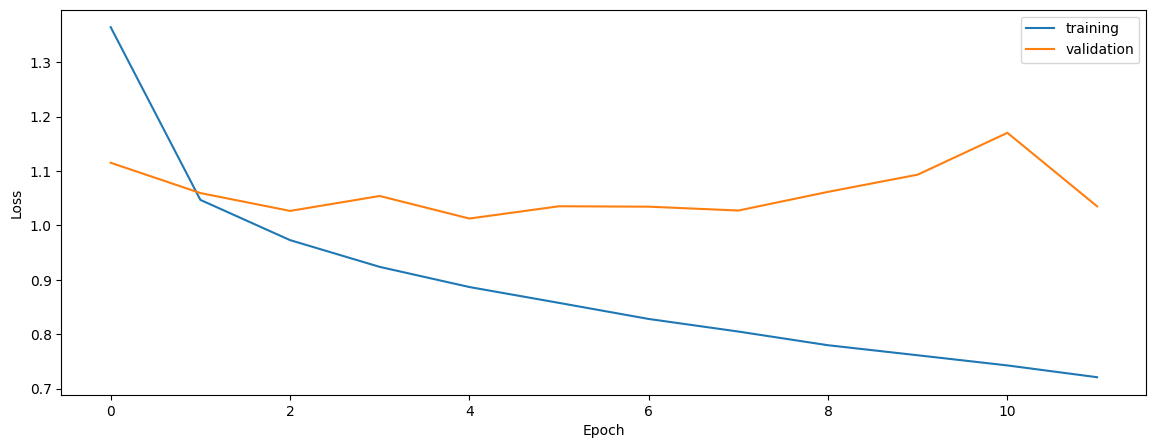

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['threshold'] = 0.6
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 828)
(1068345, 1)
validation
(123115, 828)
(123115, 1)
test
(152076, 828)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

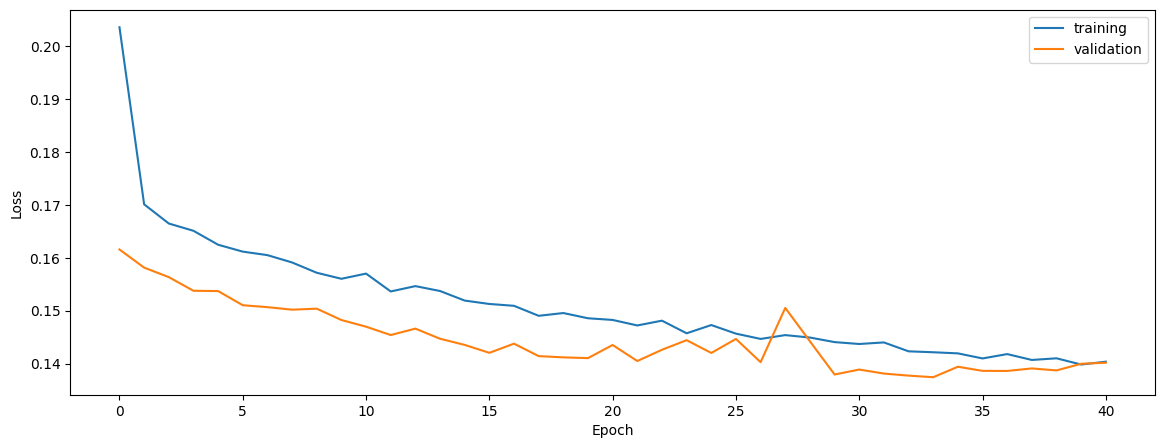

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['not_connected'] = True
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1t2','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    not_connected = np.where(reg < threshold, 1, 0)
    not_connected = np.expand_dims(not_connected,-1)
    pred = np.concatenate([pred,not_connected],-1)
    for i in range(cla.shape[-1]):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6762308920830481
0.6623144363166954
0.6282993761179704


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6714296788196688
0.6544174276598086
0.6209020276672351


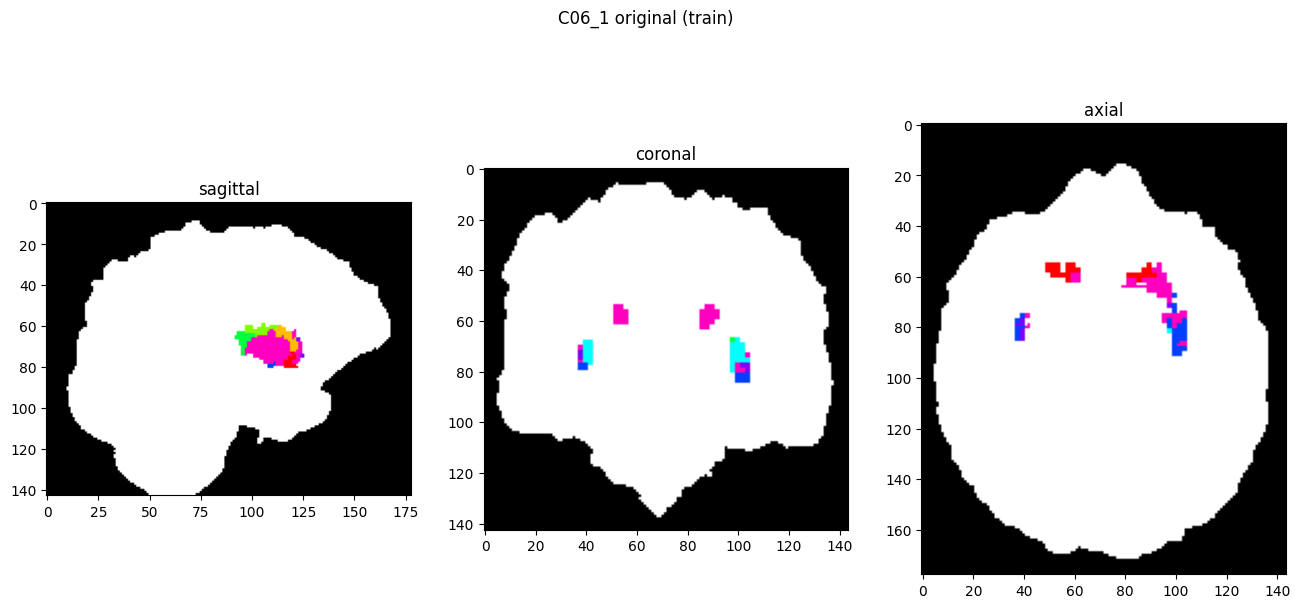

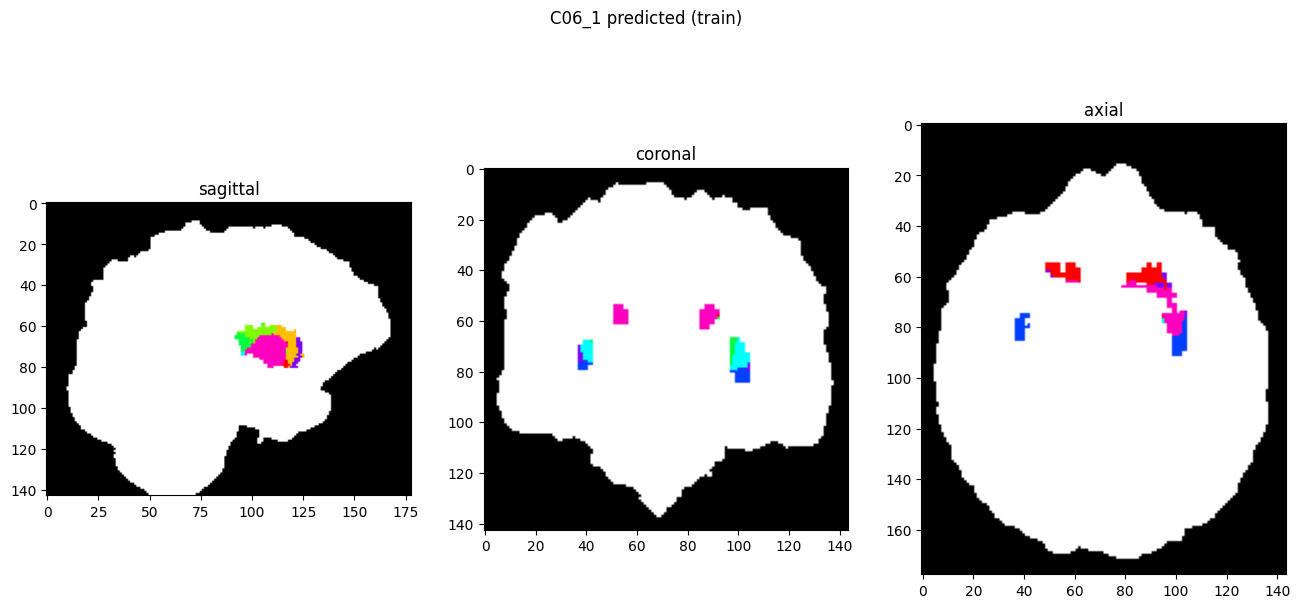

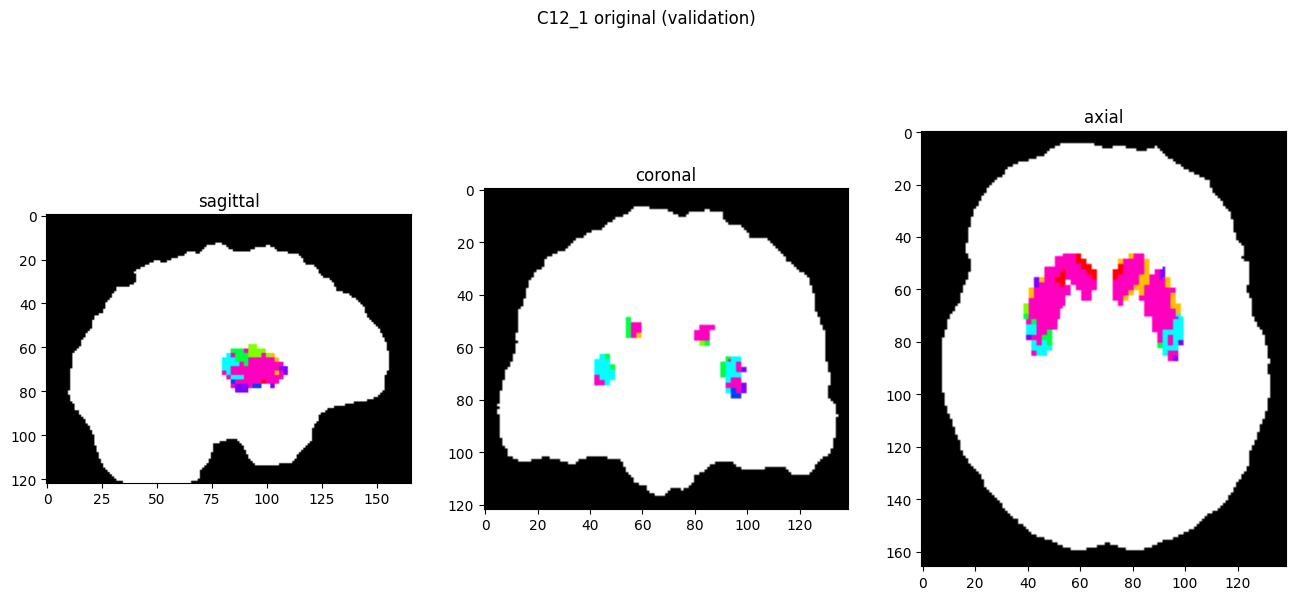

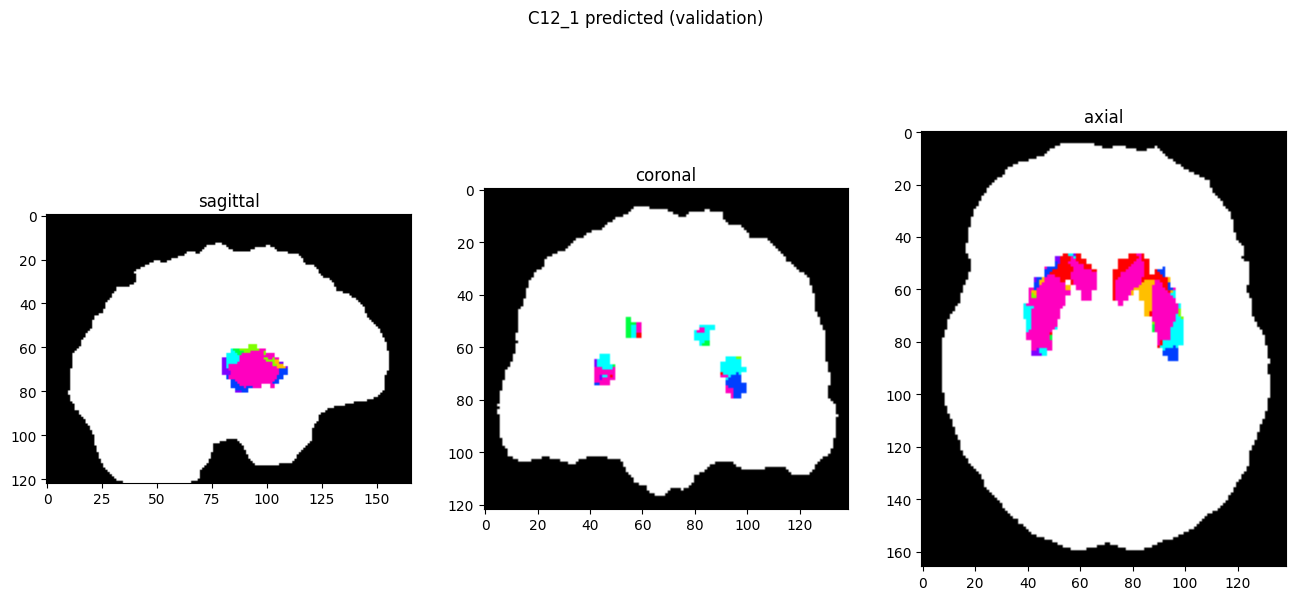

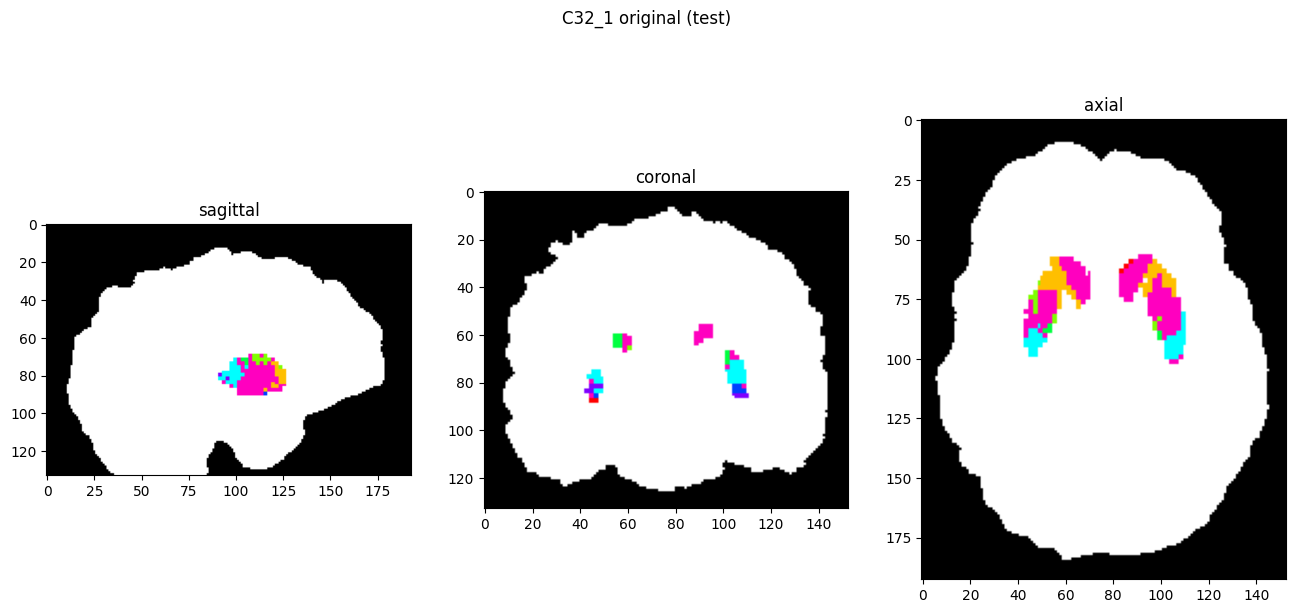

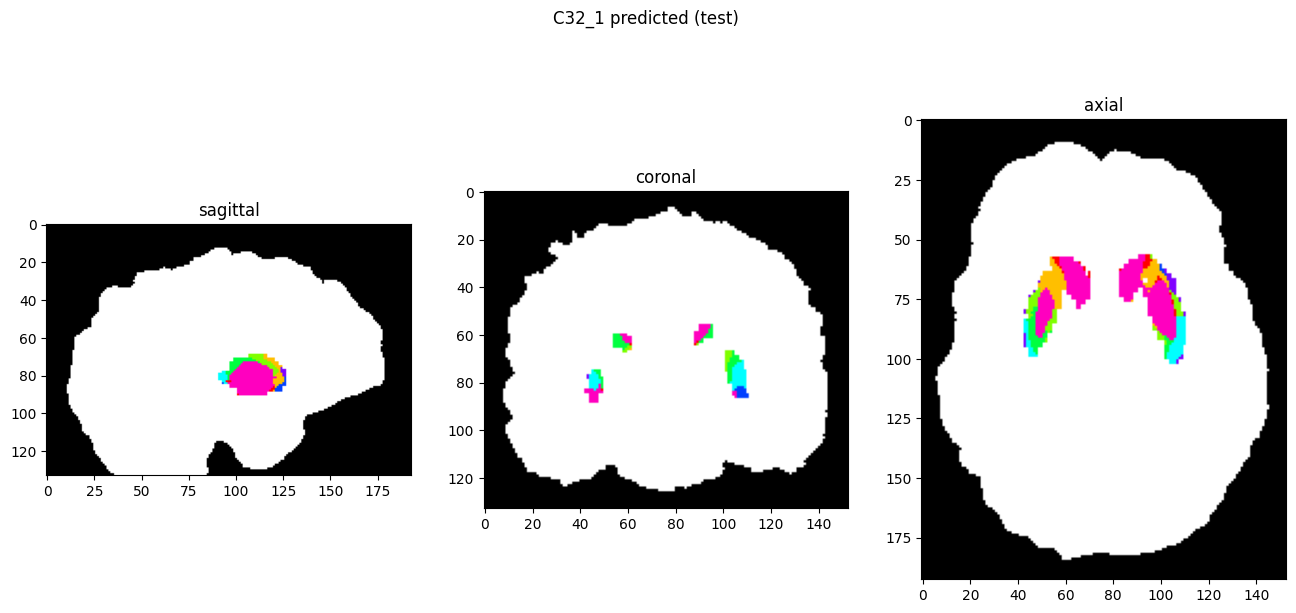

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)